In [1]:
import pandas as pd
import numpy as np
import functools as fnc
import operator as opr
import warnings

from sqlalchemy import create_engine 

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator,TransformerMixin
 
from sklearn.preprocessing import StandardScaler #, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

import lightgbm as lgb
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 131223

rmse = lambda x,y: mean_squared_error(x,y,squared=False)
rmse.__name__ = 'RMSE'
# cosine = lambda a,b : cosine_distances([a],[b]).flatten()
# cosine.__name__ = 'cosine_score'

all_regression_metrics = [mean_absolute_error,rmse,r2_score]
def print_metrics( y,pr, metrics = all_regression_metrics ):
    scores = {}
    for metric in metrics:
        scores[metric.__name__]= metric(y,pr)
        print(f"{metric.__name__}: {scores[metric.__name__]} " )
    return scores

#### Библиотека классов 

Я использую нексолько классов, отлаженных в предыдущих проектах, для понятного вывода результатов кроссвалидации.
Класс ParsedResult собирает во фрейм результаты из cv_results_ и
класс ResultPlotter строит графики из этого фрейма
Класс Styler - вспомогательный для автоматического выбора типа линий

In [3]:
class ParsedResult:
    def __init__(self,result,metric_name='score',sample_name='mean'):
        self.df = pd.DataFrame.from_dict( 
            { k:v for k,v in result.items() if k not in ['params']}
        )
# drop param_ prefix from column names for tidy display         
        self.primary_score=f"{sample_name}_test_{metric_name}"
        param_names = [ c for c in self.df.columns if c[:6]=='param_' ]        
        self.param_cols = [ c[6:] for c in param_names ]              
        self.df = self.df.rename( columns={ p:c for p,c in zip(param_names,self.param_cols) } )
# also drop model_ prefix which we use for model grid in pipeline   
        model_names = [ c for c in self.df.columns if c[:7]=='mod__' ]
        self.param_cols = [c[7:]  if c[:7]=='mod__' else c for c in self.param_cols ]
        self.model_cols = [ c[7:] for c in model_names ]   
        self.df = self.df.rename( columns={ p:c for p,c in zip(model_names,self.model_cols) } )
# select parameters, for which tested several values and arrange them descending (by number of differnt values)
        values_per_cols = list(zip( self.param_cols,[ len( np.unique( self.df[c].values ) ) for c in self.param_cols]))
        self.multi_value_cols =[it[0] for it in sorted(values_per_cols, key=lambda pair:pair[1],reverse=True) if it[1]>1 ]
# some object columns may be not string (f.e. lists)
        for i in range(len(self.df.columns)):
            if self.df.dtypes[i]=='object':
                self.df[self.df.columns[i]] = self.df[self.df.columns[i]].astype(str)
        
            
    def select(self, index,values=[],filters={},agg=[] ):
        values = [ [self.primary_score] ,values][bool(values)]
        if len(filters)>0 :
            condition = 'and'.join([ f" {k}=={v} " for k,v in filters.items() ]) 
            filtered = self.df.query(condition)    
        else:
            filtered = self.df
        cols = [ c for c in self.multi_value_cols if c not in list(filters.keys())+[index]+values ]      
        return(self.df.pivot_table(index=index,values=values,columns=cols)  )

In [4]:
class Styler:
    base_array=[]
    def __init__(self,param_array=[]):
        self.params = [ self.base_array,param_array][bool(param_array)]
    
    def key(self):
        pass
    
    def put(self,dct,index):
        dct[self.key()] = self.params[index]
        
class ColorStyler(Styler):
    base_array=[*'rgbykm']
    def key(self):
        return('color')

class DashStyler(Styler):
    base_array=['--',':','-.','-']
    def key(self):
        return('ls')
    
class WidthStyler(Styler):
    base_array=[ 2,4,7]
    def key(self):
        return('lw')

class AlphasStyler(Styler):
    base_array=[ .3,.9]
    def key(self):
        return('alpha')

In [5]:
multiply = lambda array: fnc.reduce( opr.mul,array,1 )
class ResultPlotter:
    base_params = {
        'colors':[*'rgbykm'],
        'styles':['--',':','-.','-',(0, (1, 10)),(0, (5, 10))],
        'widths':[ 2,4,7],
        'alphas':[.3,.8],
        'figsize': (20,8),
        'logscale':""
    }
    
    def __init__(self, test, params = {} ):
 #       self.model = test.model
        self.df= test#.sel
        self.params=self.base_params | params
        self.stylers = [ColorStyler(self.params['colors']),DashStyler(self.params['styles']),
                        WidthStyler(self.params['widths']),AlphasStyler(self.params['alphas'])]
        self.mcols = self.df.columns      
        self.lev_names = list(self.mcols.names)
        self.num_levels= len(self.lev_names)
        self.level_sizes=[ len(set(self.mcols.get_level_values(x))) for x in self.lev_names]
        
        # if level 0("values of pivot") is one-valued, then start apply styles from columns 1  
        self.start_level = int(  self.level_sizes[0] == 1   )
# TODO: refactoring needed here, one or two new functions to encapsulate this feature
#       also to print short description for " result thread" 

        

# auxliary func to forms sequence of indexes for levels
# result is need index on the level  which may be one of color|dashstyle|linewidth
    def idx_on_level(self,idx, lev_num):
        items_on_hyperplane = multiply(self.level_sizes[(lev_num+1):]) 
        return idx//items_on_hyperplane% self.level_sizes[lev_num]
    
    def plot(self):
        fig,ax = plt.subplots(figsize=(20,12))
        if 'x' in self.params['logscale'].lower():
            ax.set_xscale('log')
        if not self.lev_names[0]:
            self.lev_names[0]='res.thread'
            
        for i_mcol in range(len( self.mcols)):
            graph_params = {}
            for i_level in range(self.start_level,self.num_levels):
                self.stylers[i_level-self.start_level].put( graph_params, self.idx_on_level(i_mcol,i_level) ) 
            idx=self.mcols[i_mcol]
            
            levels_for_label=[ f"{n}:{j} " for n,j in zip(self.lev_names[self.start_level:],idx[self.start_level:]) ] 
            graph_params['label'] = ','.join( levels_for_label )
            ax.plot(self.df[idx] ,**graph_params)
            ax.set_title(f"Тест {self.params['title']}")
            ax.set_xlabel('learning rate')
            ax.set_ylabel(f"{self.params['metric']}")
            ax.legend()

## Загрузка

In [6]:
db_config = {
'user': 'praktikum_student',# имя пользователя
'pwd': 'Sdf4$2;d-d30pp',# пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения
'db': 'data-science-final'# название базы данных,
}
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string) 

#### Предварительный анализ данных о температуре

Таблица с даными о температуре наиболее важна, она содержит целевой признак и там больше всего вопросов с корректностью данных

Во-первых, к сожалению, в таблице нет даты замеров , только время, поэтому довольно сложно обработать те партии , где в измерениях  есть переход через границу суток.

In [7]:
q_temp_intervals = f'''
select 
  key,
  min(t."MesaureTime") min_time,
  max(t."MesaureTime") max_time,
   extract('epoch' from max(t."MesaureTime") - min(t."MesaureTime")) interval_sec
 from steel.data_temp t
group by key
'''
df_temp_intervals = pd.read_sql_query(q_temp_intervals, con=engine)
df_temp_intervals[abs(df_temp_intervals.interval_sec)>12*3600].sort_values(by='interval_sec',ascending=False)

,key,min_time,max_time,interval_sec
2813,2744,00:01:02,23:57:55,86213.0
50,2855,00:00:48,23:57:35,86207.0
1682,2063,00:01:46,23:58:18,86192.0
201,2526,00:01:42,23:57:34,86152.0
1681,2827,00:00:27,23:56:10,86143.0
...,...,...,...,...
1625,1263,00:21:02,23:41:29,84027.0
2764,46,00:42:24,23:55:12,83568.0
225,44,00:35:31,22:50:26,80095.0
3046,1958,01:51:42,22:43:59,75137.0


Найдена 71 партия, где разброс времени почти на сутки. Визуально понятно, что это серии продолжительностью до 3 часов, которые начались в разные дни, но автоматически находить в них первое и последнее значение довольно сложно.
Я все же решил их выбросить -
во-первых их немного, по сравнению с общим количеством, и с теми данными, которые все равно придется удалять
во-вторых в реальной производственной задаче я бы попросил полное время с датой, наверняка это несложно реализовать.

Следующий момент -есть много партий только с одним валидным замером - там либо пустые значения, либо температура меньше 1500. Как я понимаю фраза  <i>"значения температуры ниже 1500 градусов — аномальные"</i> означает, что использовать их нельзя 

In [8]:
q_temp_count = f'''
select count(*) from (
    select key
     from steel.data_temp t
     where t."Temperature" >= 1500 
    group by key
    having count(*)=1
)  c1   
'''
pd.read_sql_query(q_temp_count, con=engine)

,count
0,740


Всего таких серий 740 , так как по серии с одним замером нельзя ни обучить модель, ни проверить предсказания, эти данные бесполезны и их придется удалить.

Следующее условие на температуры для серий позволяет исключить такие данные ( с одним значением температуры или с переходом через сутки) уже на этапе загрузки.
Все загружаемые таблицы будут объединяться  с таким запросом по полю <i>key</i>

In [9]:
correct_temp_clause = f'''
   select key,
      m_temp,
      y_temp,
      qty_temp,
      min(temp_time) begin_time,
      extract('epoch' from max(temp_time ) - min(temp_time)) t_temp   
      from ( 
        select 
           tmr.key, 
           tmr."MesaureTime" temp_time, 
           first_value(tmr."Temperature") over (partition by key order by tmr."MesaureTime"
              rows between unbounded preceding and unbounded following ) m_temp,
           last_value(tmr."Temperature") over (partition by key order by tmr."MesaureTime" 
              rows between unbounded preceding and unbounded following ) y_temp,
           count(tmr."Temperature") over (partition by key order by tmr."MesaureTime" 
              rows between unbounded preceding and unbounded following ) qty_temp 
         from steel.data_temp tmr  
         where tmr."Temperature" >= 1500 and tmr."Temperature" is not null 
      )  temp_window
      group by key,m_temp,y_temp,qty_temp
      having count(*) >1 
       and max(temp_time)- min(temp_time) < interval '12 hours'
'''              

mean = 1589.1,std=25.02


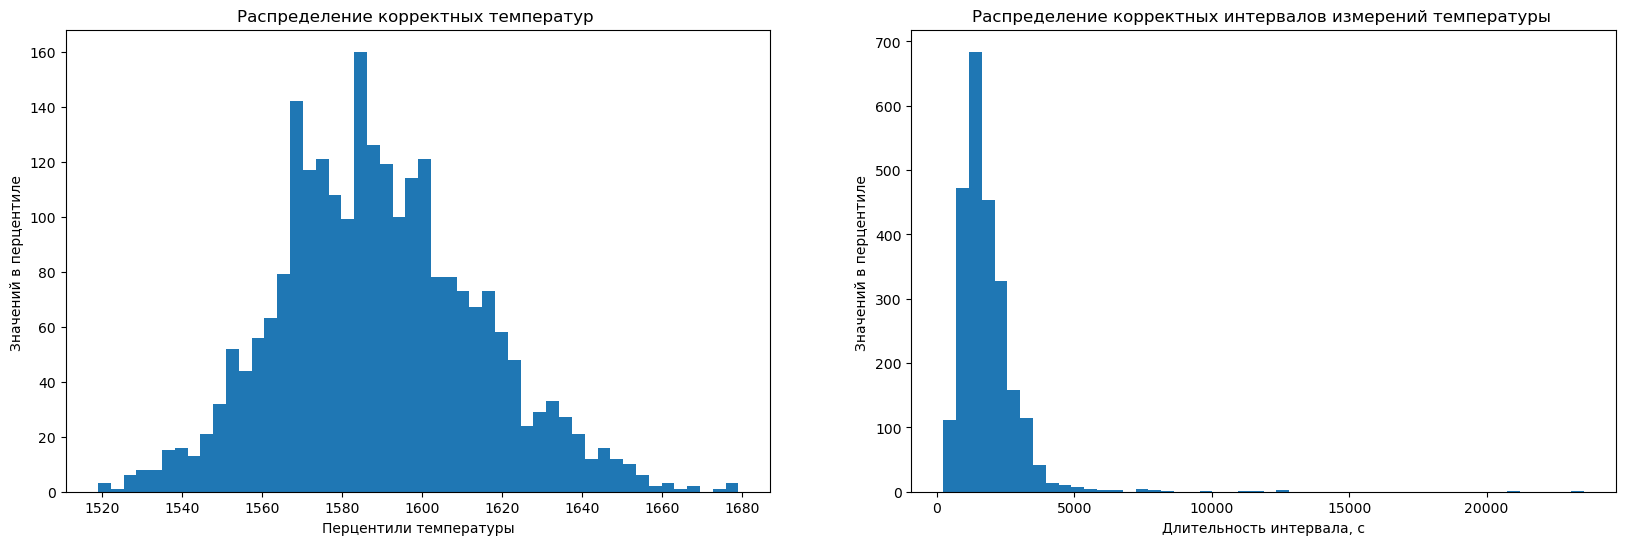

In [10]:
q_temp = f'''
select dt."MesaureTime" time,dt."Temperature" temp ,ct.t_temp 
  from steel.data_temp dt
  join ( {correct_temp_clause} ) ct
  using(key)
  where dt."MesaureTime" = begin_time
'''
df_temp = pd.read_sql_query(q_temp, con=engine)
df_temp= df_temp[df_temp.temp>1500]
fig,axs = plt.subplots(1,2,figsize=(20,6))
axs[0].hist(df_temp.temp,bins=50)
axs[0].set_title('Распределение корректных температур ')
axs[0].set_xlabel('Перцентили температуры')
axs[0].set_ylabel('Значений в перцентиле ')
axs[1].hist(df_temp.t_temp,bins=50)
axs[1].set_title('Распределение корректных интервалов измерений температуры ')
axs[1].set_xlabel('Длительность интервала, с')
axs[1].set_ylabel('Значений в перцентиле ')
mean_,std_ = df_temp.temp.agg(['mean','std'])
print(f"mean = {round(mean_,1)},std={round(std_,2)}")

Для корректных серий можно посмотреть распределение значений интервала измерений и температуры.   
Температура аккуратно распределена примерно по нормальному закону в диапазоне - 1520-1680   
У интервалов измерений распределение видимо пуассоновское с длинным хвостом вверх   
Хотя основная масса измерений в интервале до полутора часов , есть 7 измерений в интервале 4-6ч,  
 но тут нельзя сказать, что это что-то нереальное, вполне возможно такие измерения действительно проводились.

In [11]:
df_temp[df_temp.t_temp> 10_000].sort_values(by='t_temp',ascending=False)

,time,temp,t_temp
2165,15:28:21,1583.0,23537.0
1645,14:09:40,1639.0,20923.0
1496,19:29:28,1588.0,12789.0
491,01:20:29,1638.0,12753.0
1623,07:12:25,1584.0,12643.0
1493,05:57:28,1606.0,11819.0
1534,20:02:20,1553.0,10954.0


#### Анализ данных о нагреве

В большинстве серий есть несколько этапов нагрева.  
Я буду называть их "плавками" (melts) , хотя с инженерной точки зрения это возможно некорректно.  
Так как время начала плавки вряд ли на что-то влияет, нас интересуют три параметра - длительность плавки и активная/реактивные мощности.

22
CPU times: user 135 ms, sys: 33.4 ms, total: 168 ms
Wall time: 421 ms


Text(0, 0.5, 'Значений в перцентиле ')

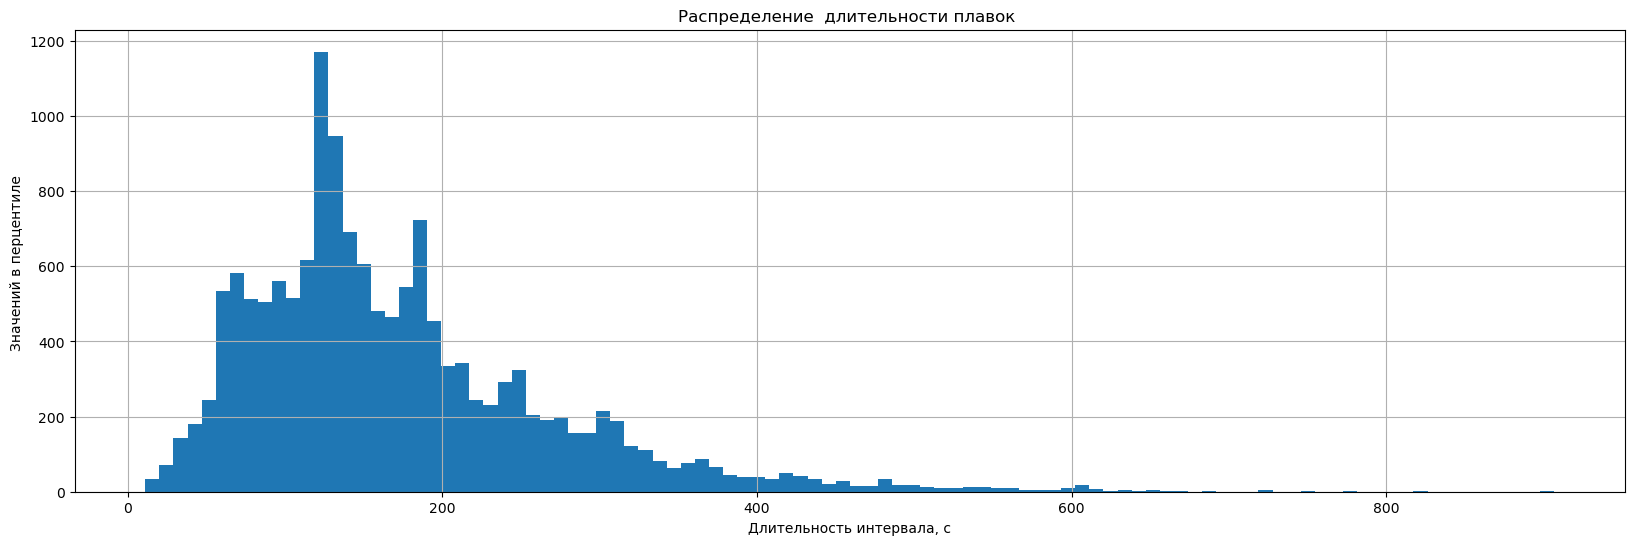

In [12]:
%%time
q_arc = """
select da.key,da."BeginHeat",da."EndHeat",da."ActivePower" act,da."ReactivePower" react,
  extract('epoch' from da."EndHeat"-da."BeginHeat") seconds 
  from steel.data_arc da 
"""
df_arc = pd.read_sql_query(q_arc, con=engine) 
print(df_arc[-df_arc.seconds>3600*4].shape[0] )
df_arc = df_arc[-df_arc.seconds<3600*4]
df_arc.seconds.hist(bins=100,figsize= (20,6));
plt.title('Распределение  длительности плавок ')
plt.xlabel('Длительность интервала, с')
plt.ylabel('Значений в перцентиле ')

Длительность плавки распределена примерно по Пуассону с резкими пиками вблиза максимума. 
Хвост образуют 10 плавок с длительностью 600-1000 секунд, не вижу признаков, что это какая-то аномалия

In [13]:
df_arc[df_arc.seconds > 600].sort_values(by='seconds',ascending = False).head(10)

,key,BeginHeat,EndHeat,act,react,seconds
7799,1689,18:49:03,19:04:10,3.731596,2.676388,907.0
12425,2701,06:11:16,06:25:02,3.150762,2.397032,826.0
7433,1616,09:07:06,09:20:06,2.943082,1.998065,780.0
2940,640,01:25:40,01:38:06,2.766592,2.236813,746.0
4655,1005,05:59:14,06:11:19,2.975003,2.006356,725.0
2662,580,18:06:25,18:18:29,2.940772,2.211983,724.0
9227,2001,20:19:15,20:31:16,3.156276,2.504206,721.0
14200,3086,03:41:09,03:53:10,3.052813,2.216230,721.0
11741,2560,06:02:36,06:14:37,2.991186,2.099555,721.0
10976,2387,06:27:55,06:39:20,2.999812,2.197359,685.0


Мощность загрузки распределена естествнным образом.  
Единственной аномалией является большая отрицательная реактивная мощность для одной серии, её лучше исключить при загрузке  

In [14]:
df_arc[(df_arc.act<0) | (df_arc.react<0)  ]

,key,BeginHeat,EndHeat,act,react,seconds
9781,2116,00:44:48,00:46:37,0.495782,-715.504924,109.0


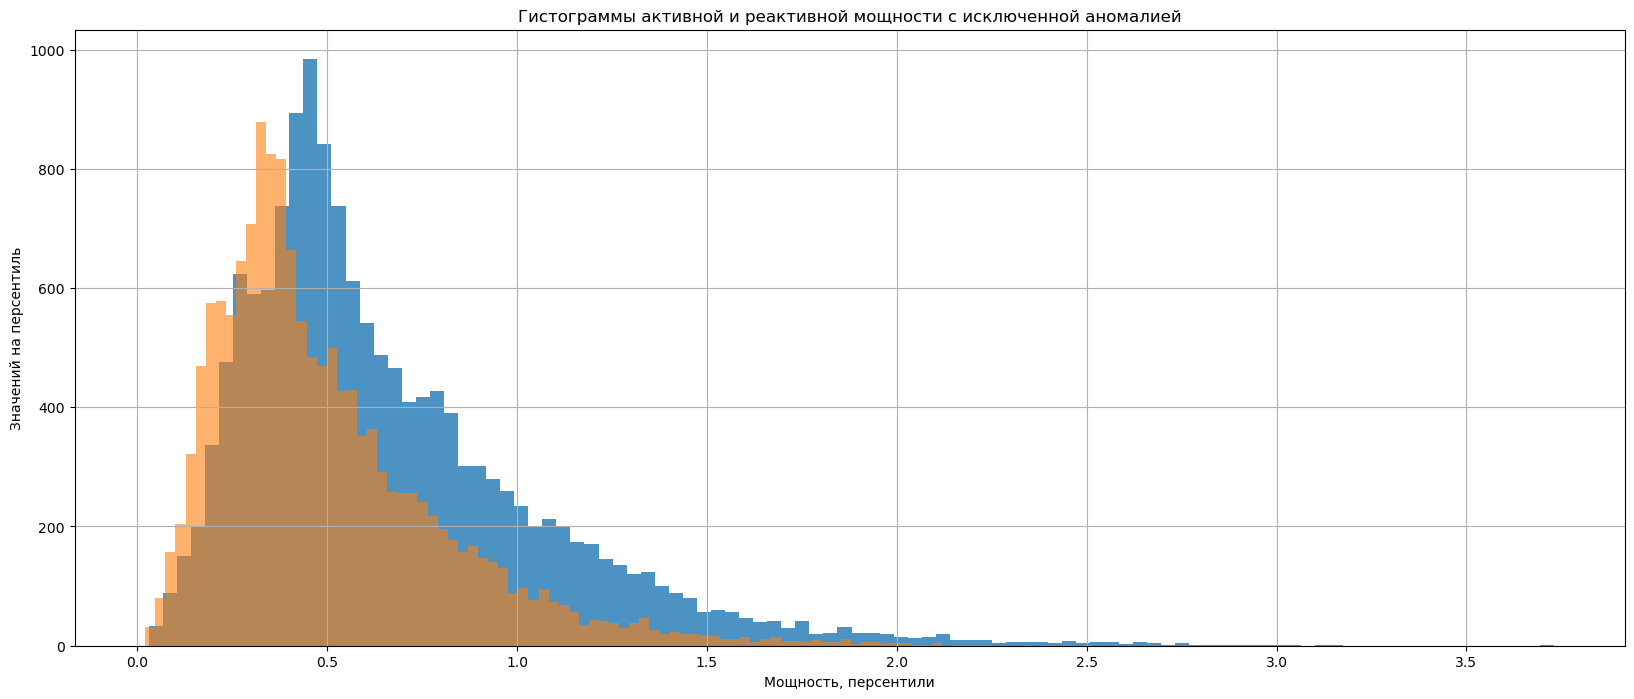

In [15]:
df_arc = df_arc[(df_arc.act>=0)&(df_arc.react>=0)]
df_arc.act.hist(bins=100,alpha=.8,figsize =(20,8));
df_arc.react.hist(bins=100,alpha=.6);
plt.xlabel('Мощность, персентили');
plt.ylabel('Значений на персентиль');
plt.title('Гистограммы активной и реактивной мощности с исключенной аномалией');
plt.show()

#### Таблицы загрузки материалов 

Про таблицы bulk/wire можно сказать только что
- все записи для партий на месте и там есть хотя бы одна загрузка для каждой партии
- очень много пустых значений, поэтому по самим данным таблицы ничего о них сказать нельзя
Более подробный анализ можно провести после загрузки данных в общий фрейм и сопоставлении их с другими

In [16]:
%%time
q_bulk = """
select *  
  from steel.data_bulk db 
  join steel.data_bulk_time dbt using(key); 
"""
df_bulk = pd.read_sql_query(q_bulk, con=engine) 
df_bulk.info()
pd.concat( [df_bulk.head(),df_bulk.sample(10),df_bulk.tail()] )


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 31 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
 16  Bulk 1   252 non-null    object 
 17  Bulk 2   22 non-null     object 
 18  Bulk 3   1298 non-null   object 
 19  Bulk 4   1014 non-null   object 
 20  Bulk 5   77 non-null     object 
 21  Bulk 6   576 n

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56
1903,1966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,11:27:31,11:04:09,None,11:04:09,11:04:09
1289,1337,NaN,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,09:13:42,None,09:13:42,09:13:42
1651,1709,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,05:09:14,None,05:09:14,05:09:14
1726,1785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,16:52:57,None
506,532,54.0,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,01:38:59,None,01:38:59,None


In [17]:
%%time
q_wire = """
select *  
  from steel.data_wire dw
  join steel.data_wire_time dwt using(key); 
"""
df_wire = pd.read_sql_query(q_wire, con=engine) 
df_wire.info()
pd.concat( [df_wire.head(),df_wire.sample(10),df_wire.tail()] )


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
 10  Wire 1  3055 non-null   object 
 11  Wire 2  1079 non-null   object 
 12  Wire 3  63 non-null     object 
 13  Wire 4  14 non-null     object 
 14  Wire 5  1 non-null      object 
 15  Wire 6  73 non-null     object 
 16  Wire 7  11 non-null     object 
 17  Wire 8  19 non-null     object 
 18  Wire 9  29 non-null     object 
dtypes: float64(9), int64(1), object(9)
memory usage: 457.5+ KB
CPU times: user 17.8 ms, sys: 0 ns, total: 17.8 ms
W

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:11:41,None,None,None,None,None,None,None,None
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:46:10,None,None,None,None,None,None,None,None
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:13:47,None,None,None,None,None,None,None,None
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12:48:05,None,None,None,None,None,None,None,None
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13:18:15,13:32:06,None,None,None,None,None,None,None
1541,1620,115.128006,65.115440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:46:53,11:46:55,None,None,None,None,None,None,None
642,678,96.080399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09:01:43,None,None,None,None,None,None,None,None
118,134,NaN,NaN,NaN,NaN,NaN,26.151842,NaN,NaN,NaN,None,None,None,None,None,10:04:54,None,None,None
79,94,37.215358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15:45:27,None,None,None,None,None,None,None,None
403,435,125.236801,109.360160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11:10:37,11:12:16,None,None,None,None,None,None,None


### Рабочая загрузка

Все данные загружаются в один фрейм , где строка соответствует одной партии.   
Загрузки материалов (data_bulk) и газа уже имеют подходящую организацию с уникальным номером партии ,
поэтому их можно просто объединить по ключу партии (key) 

Я стремился уже призгрузке отсечь как можно больше лишних данных и провести по возомжности больше преобразований, 
чтобы не растаскивать различные датафреймы по проекту и не путаться в них.  
Так, все время сразу при загрузке перевозится  в секунды относительно первого измерения температуры,   
так как их все равно надо преобразовывать в числа для моделей 
Сама колонка  времени первого измерения <b>begin_time</b> остается time, но она только для ориентировки и в расчетах не используется.

Так как придется выполнять с колонками разшичные групповые операции, их имена подобраны для удобства такой группировки.  
Имя колонки состоит из двухбуквенного префикса, определяющего её тип , подчеркивания и номера.   
Первая буква префикса - <b>m</b> для "материальных колонок " и  <b>t</b> - для "временных"   
Вторая буква префикса - <b>b, w</b> или <b>g</b> - показывает таблицу - источник данных (bulk/wire/gas) 

Наконец, создаются специальные колонки   
<b>m_temp</b> - первое изменение температуры 
<b>y_temp</b> - цель - последнее изменение температуры 

In [18]:
bulk_clause =", ".join([f'b."Bulk {i}" mb_{i}, \
    extract("epoch" from bt."Bulk {i}")-extract("epoch" from begin_time) tb_{i}' 
                        for i in range(1,16)])
wire_clause =", ".join([f'w."Wire {i}" mw_{i}, \
    extract("epoch" from wt."Wire {i}") - extract("epoch" from begin_time) tw_{i}' 
                        for i in range(1,10)])

q_bulk_wire = f"""
  select key,gas m_gas,
    {bulk_clause},
    {wire_clause},
    m_temp,t_temp,y_temp,begin_time,qty_temp
  from steel.data_bulk b  
  join steel.data_bulk_time bt using(key)
  join steel.data_wire w using(key)
  join steel.data_wire_time wt using(key)
  join steel.data_gas g using(key)
  join ( {correct_temp_clause}
    ) temp_agg using(key)
 order by key,begin_time desc
"""
f_bulk_wire = pd.read_sql_query(q_bulk_wire, con=engine) 
f_bulk_wire.info()
pd.concat( [f_bulk_wire.head(),f_bulk_wire.sample(10),f_bulk_wire.tail()] )


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275 entries, 0 to 2274
Data columns (total 55 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2275 non-null   int64  
 1   m_gas       2275 non-null   float64
 2   mb_1        194 non-null    float64
 3   tb_1        194 non-null    float64
 4   mb_2        13 non-null     float64
 5   tb_2        13 non-null     float64
 6   mb_3        940 non-null    float64
 7   tb_3        940 non-null    float64
 8   mb_4        796 non-null    float64
 9   tb_4        796 non-null    float64
 10  mb_5        49 non-null     float64
 11  tb_5        49 non-null     float64
 12  mb_6        424 non-null    float64
 13  tb_6        424 non-null    float64
 14  mb_7        13 non-null     float64
 15  tb_7        13 non-null     float64
 16  mb_8        1 non-null      float64
 17  tb_8        1 non-null      float64
 18  mb_9        12 non-null     float64
 19  tb_9        12 non-null    

,key,m_gas,mb_1,tb_1,mb_2,tb_2,mb_3,tb_3,mb_4,tb_4,...,tw_7,mw_8,tw_8,mw_9,tw_9,m_temp,t_temp,y_temp,begin_time,qty_temp
0,1,29.749986,NaN,NaN,NaN,NaN,NaN,NaN,43.0,312.0,...,NaN,NaN,NaN,NaN,NaN,1571.0,861.0,1613.0,11:16:18,5
1,2,12.555561,NaN,NaN,NaN,NaN,NaN,NaN,73.0,551.0,...,NaN,NaN,NaN,NaN,NaN,1581.0,1305.0,1602.0,11:37:27,6
2,3,28.554793,NaN,NaN,NaN,NaN,NaN,NaN,34.0,1069.0,...,NaN,NaN,NaN,NaN,NaN,1596.0,1300.0,1599.0,12:13:17,5
3,4,18.841219,NaN,NaN,NaN,NaN,NaN,NaN,81.0,-254.0,...,NaN,NaN,NaN,NaN,NaN,1601.0,388.0,1625.0,12:52:57,3
4,5,5.413692,NaN,NaN,NaN,NaN,NaN,NaN,78.0,-269.0,...,NaN,NaN,NaN,NaN,NaN,1576.0,762.0,1602.0,13:23:19,2
1396,1538,18.137567,NaN,NaN,NaN,NaN,60.0,613.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1558.0,1430.0,1575.0,23:00:31,6
1979,2161,11.674069,NaN,NaN,NaN,NaN,NaN,NaN,78.0,1520.0,...,NaN,NaN,NaN,NaN,NaN,1614.0,2112.0,1591.0,10:26:10,4
2108,2306,8.078719,NaN,NaN,NaN,NaN,53.0,150.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1550.0,1238.0,1586.0,06:13:52,5
847,945,15.041890,NaN,NaN,NaN,NaN,128.0,2422.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1592.0,3693.0,1584.0,09:24:14,5
1132,1253,10.265569,NaN,NaN,NaN,NaN,NaN,NaN,144.0,1079.0,...,NaN,NaN,NaN,NaN,NaN,1579.0,1537.0,1596.0,17:02:28,4


Для каждой плавки создается отдельный набор колонок -   
начало и конец плавки(<b>th* ,te* </b>), 
активная и реактивная мощности(<b> ma* , mr* </b>).  
При этом выдерживаются правила наименованимя колонок <b>m/t</b>

Чтобы развернуть таблицу плавок во фреймы,  
сначала присваиваем каждой ранг по времени в пределах ключа,   
затем для каждого ранга созаетм группу колонок.

In [19]:
max_melts = 15
arc_clause = ', '.join([
f"min( case when rk={i} then begin_heat end) th_{i},\
min( case when rk={i} then end_heat end) te_{i},\
sum(case when rk={i} then pa end) ma_{i},\
sum( case when rk={i} then pr end) mr_{i}"
for i in range(1,max_melts+1)])

arc_temp_clause = ", ".join([
    f"ma_{i},mr_{i},\
    extract('epoch' from th_{i}-begin_time) th_{i},\
    extract('epoch' from te_{i}-begin_time) te_{i}"
for i in range(1,max_melts+1)])

q_arc=f"""
select key,begin_time,t_temp,
    {arc_temp_clause}
    from (
      select key,
        {arc_clause}
        from(
            select key,a0."BeginHeat" begin_heat,a0."EndHeat" end_heat,
               a0."ActivePower" pa, a0."ReactivePower" pr,
               cast( rank()  over( partition by key order by a0."BeginHeat" ) as integer) rk 
              from steel.data_arc a0 
             where a0."ActivePower" >=0 and a0."ReactivePower" >=0
       ) a1
       group by key
     ) a 
 join ( {correct_temp_clause}
 ) temp_measure using(key)
 """
f_arc = pd.read_sql_query(q_arc, con=engine) 
f_arc.info()
pd.concat( [f_arc.head(),f_arc.sample(10),f_arc.tail()] )
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421 entries, 0 to 2420
Data columns (total 63 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2421 non-null   int64  
 1   begin_time  2421 non-null   object 
 2   t_temp      2421 non-null   float64
 3   ma_1        2421 non-null   float64
 4   mr_1        2421 non-null   float64
 5   th_1        2421 non-null   float64
 6   te_1        2421 non-null   float64
 7   ma_2        2389 non-null   float64
 8   mr_2        2389 non-null   float64
 9   th_2        2389 non-null   float64
 10  te_2        2389 non-null   float64
 11  ma_3        2253 non-null   float64
 12  mr_3        2253 non-null   float64
 13  th_3        2253 non-null   float64
 14  te_3        2253 non-null   float64
 15  ma_4        1864 non-null   float64
 16  mr_4        1864 non-null   float64
 17  th_4        1864 non-null   float64
 18  te_4        1864 non-null   float64
 19  ma_5        1185 non-null  

,key,begin_time,t_temp,ma_1,mr_1,th_1,te_1,ma_2,mr_2,th_2,...,th_13,te_13,ma_14,mr_14,th_14,te_14,ma_15,mr_15,th_15,te_15
0,1,11:16:18,861.0,0.976059,0.687084,-844.0,-616.0,0.805607,0.520285,-530.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11:37:27,1305.0,0.438063,0.283043,-193.0,-56.0,1.296415,0.892914,83.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,12:13:17,1300.0,1.062053,0.671494,-383.0,-103.0,0.484206,0.312100,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,12:52:57,388.0,0.875313,0.614404,-800.0,-593.0,0.425692,0.268482,-490.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,13:23:19,762.0,0.950026,0.690523,-726.0,-475.0,0.508026,0.332352,-298.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
857,893,07:37:32,1065.0,0.361575,0.305333,-169.0,-59.0,0.907762,0.792772,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
956,994,20:29:40,1925.0,0.442361,0.324075,-183.0,-57.0,0.392245,0.291368,258.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,83,07:36:26,1266.0,0.289422,0.216174,-144.0,-63.0,0.746475,0.561370,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,1042,13:01:29,1929.0,0.431530,0.341050,-180.0,-60.0,0.551085,0.411985,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1679,1736,00:24:59,748.0,0.795875,0.568546,-227.0,-44.0,0.830164,0.552757,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Объединение данных для моделирования 

In [20]:
df = f_bulk_wire.merge(f_arc, on=['key','begin_time','t_temp'])

Создаем группы колонок в соответствии с правилами наименований.  
Для исследований создаем группы tier1,tier2,tier3 в соотсвтествие с колчичеством непустых значений в этих колонках  
Наконец для искуственных целочисленных признаков создается группа int_cols -   
пока в ней только количество плавок.

Все колнки используются как признаки, кроме begin_time и целевой y_temp 

In [21]:
magni_cols = [c for c in df.columns if c[0]=='m']
time_cols = [c for c in df.columns if c[0]=='t']

tier1_cols = [ c for c in magni_cols+time_cols if df[c].notna().sum()>=1_000 ]
magni1_cols = [ c for c in magni_cols if c in tier1_cols ]
time1_cols = [ c for c in time_cols if c in tier1_cols ]

tier2_cols = [ c for c in magni_cols+time_cols if 100 <= df[c].notna().sum()<1_000 ]
magni2_cols = [ c for c in magni_cols if c in tier2_cols ]
time2_cols = [ c for c in time_cols if c in tier2_cols ]

tier3_cols = [ c for c in magni_cols+time_cols if 1 <= df[c].notna().sum()<100 ]
begin_heat_cols = [ c for c in time_cols if c[1]=='h' ]
end_heat_cols = [ c for c in time_cols if c[1]=='e' ]
bulk_time_cols = [c for c in df.columns if c[:2]=='tb']
wire_time_cols = [c for c in df.columns if c[:2]=='tw']
bulk_cols = [c for c in df.columns if c[:2]=='mb']
wire_cols = [c for c in df.columns if c[:2]=='mw']

int_cols = [c for c in df.columns if c[:3]=='num']

null_cols = [ c for c in magni_cols+time_cols if  df[c].notna().sum() ==0 ]
null_cols


['mw_5', 'tw_5']

#### Корректировка временных интервалов

При приведении к секундам в запросе естсественно получаются значения в районе +-84_000 вследстие суточных переходов.  
Так как у нас нет объектов с временами больше  6 часов, мы можем быть уверены, что это именно суточные переходы и восстановить нормальные значения просто отняв/добавив 84_000 

In [22]:
def fix_24h_gaps(t):
    if t is not None:
        if t < -12*3600:
            t += 24*3600
        elif t> 12*3600:
            t -= 24*3600
    return t 

for c in time_cols:
    df[c] = df[c].apply(fix_24h_gaps )

Есть операции(в основном плавки) проведенные после последнего измерения температуры.   
Объектино они не влияют на резултьтат, но вносят шум в модель, поэтому я считаю правильным их стереть.

In [23]:
def fix_beyond_measures(row):  
    for i in range(1,len(bulk_time_cols)+1):
        if row[f"tb_{i}"] is not None:
            if row[f"tb_{i}"]>row["t_temp"]:
                row[f"tb_{i}"]=None
                row[f"mb_{i}"]=None
    for i in range(1,len(wire_time_cols)+1):
        if row[f"tw_{i}"] is not None:
            if row[f"tw_{i}"]>row["t_temp"]:
                row[f"tw_{i}"]=None
                row[f"mw_{i}"]=None
    for i in range(1,len(begin_heat_cols)+1):
        if row[f"th_{i}"] is not None:
            if row[f"th_{i}"]>row["t_temp"]:
                row[f"th_{i}"]=None
                row[f"te_{i}"]=None        
                row[f"ma_{i}"]=None
                row[f"mr_{i}"]=None  
            
    return row

df = df.apply(fix_beyond_measures,axis=1)

Что касвется операций до первого измерения, то на итоговую темпетратуру, они в принципе могут влиять ,
по крайней мере легирующие добавки меняют  свойства сплава ( теплоемкость и теплопроводность).   
Обычные плавки вроде влиять не должны, но вообще тут лучше на всякий случай советоваться с технологами .   
Пока я решил их оставить.    

In [24]:
num_melts = df[begin_heat_cols].notna().astype(int).sum(axis=1)
df = pd.concat([df,pd.Series( num_melts, name= 'num_melts')],axis=1) 
int_cols = [c for c in df.columns if c[:3]=='num']

Проверим что партий без плавок нет

In [25]:
df[df.num_melts == 0][begin_heat_cols]

,th_1,th_2,th_3,th_4,th_5,th_6,th_7,th_8,th_9,th_10,th_11,th_12,th_13,th_14,th_15


## Проверка загруженных данных

#### Проверка аномалий в объединенном фрейме

In [26]:
df.y_temp.agg(['max','min','count','mean','std'])

max      1653.000000
min      1541.000000
count    2275.000000
mean     1593.384176
std        11.174561
Name: y_temp, dtype: float64

Параметры распределения целевого   признака не изменились 

У нас всего 2200 записей (т.е меньше 2000 для обучения), так что трудно определить являются экстремальные значения выбросами или вариантом нормы. Проверим признаки из tier1 , где записей достаточно много 

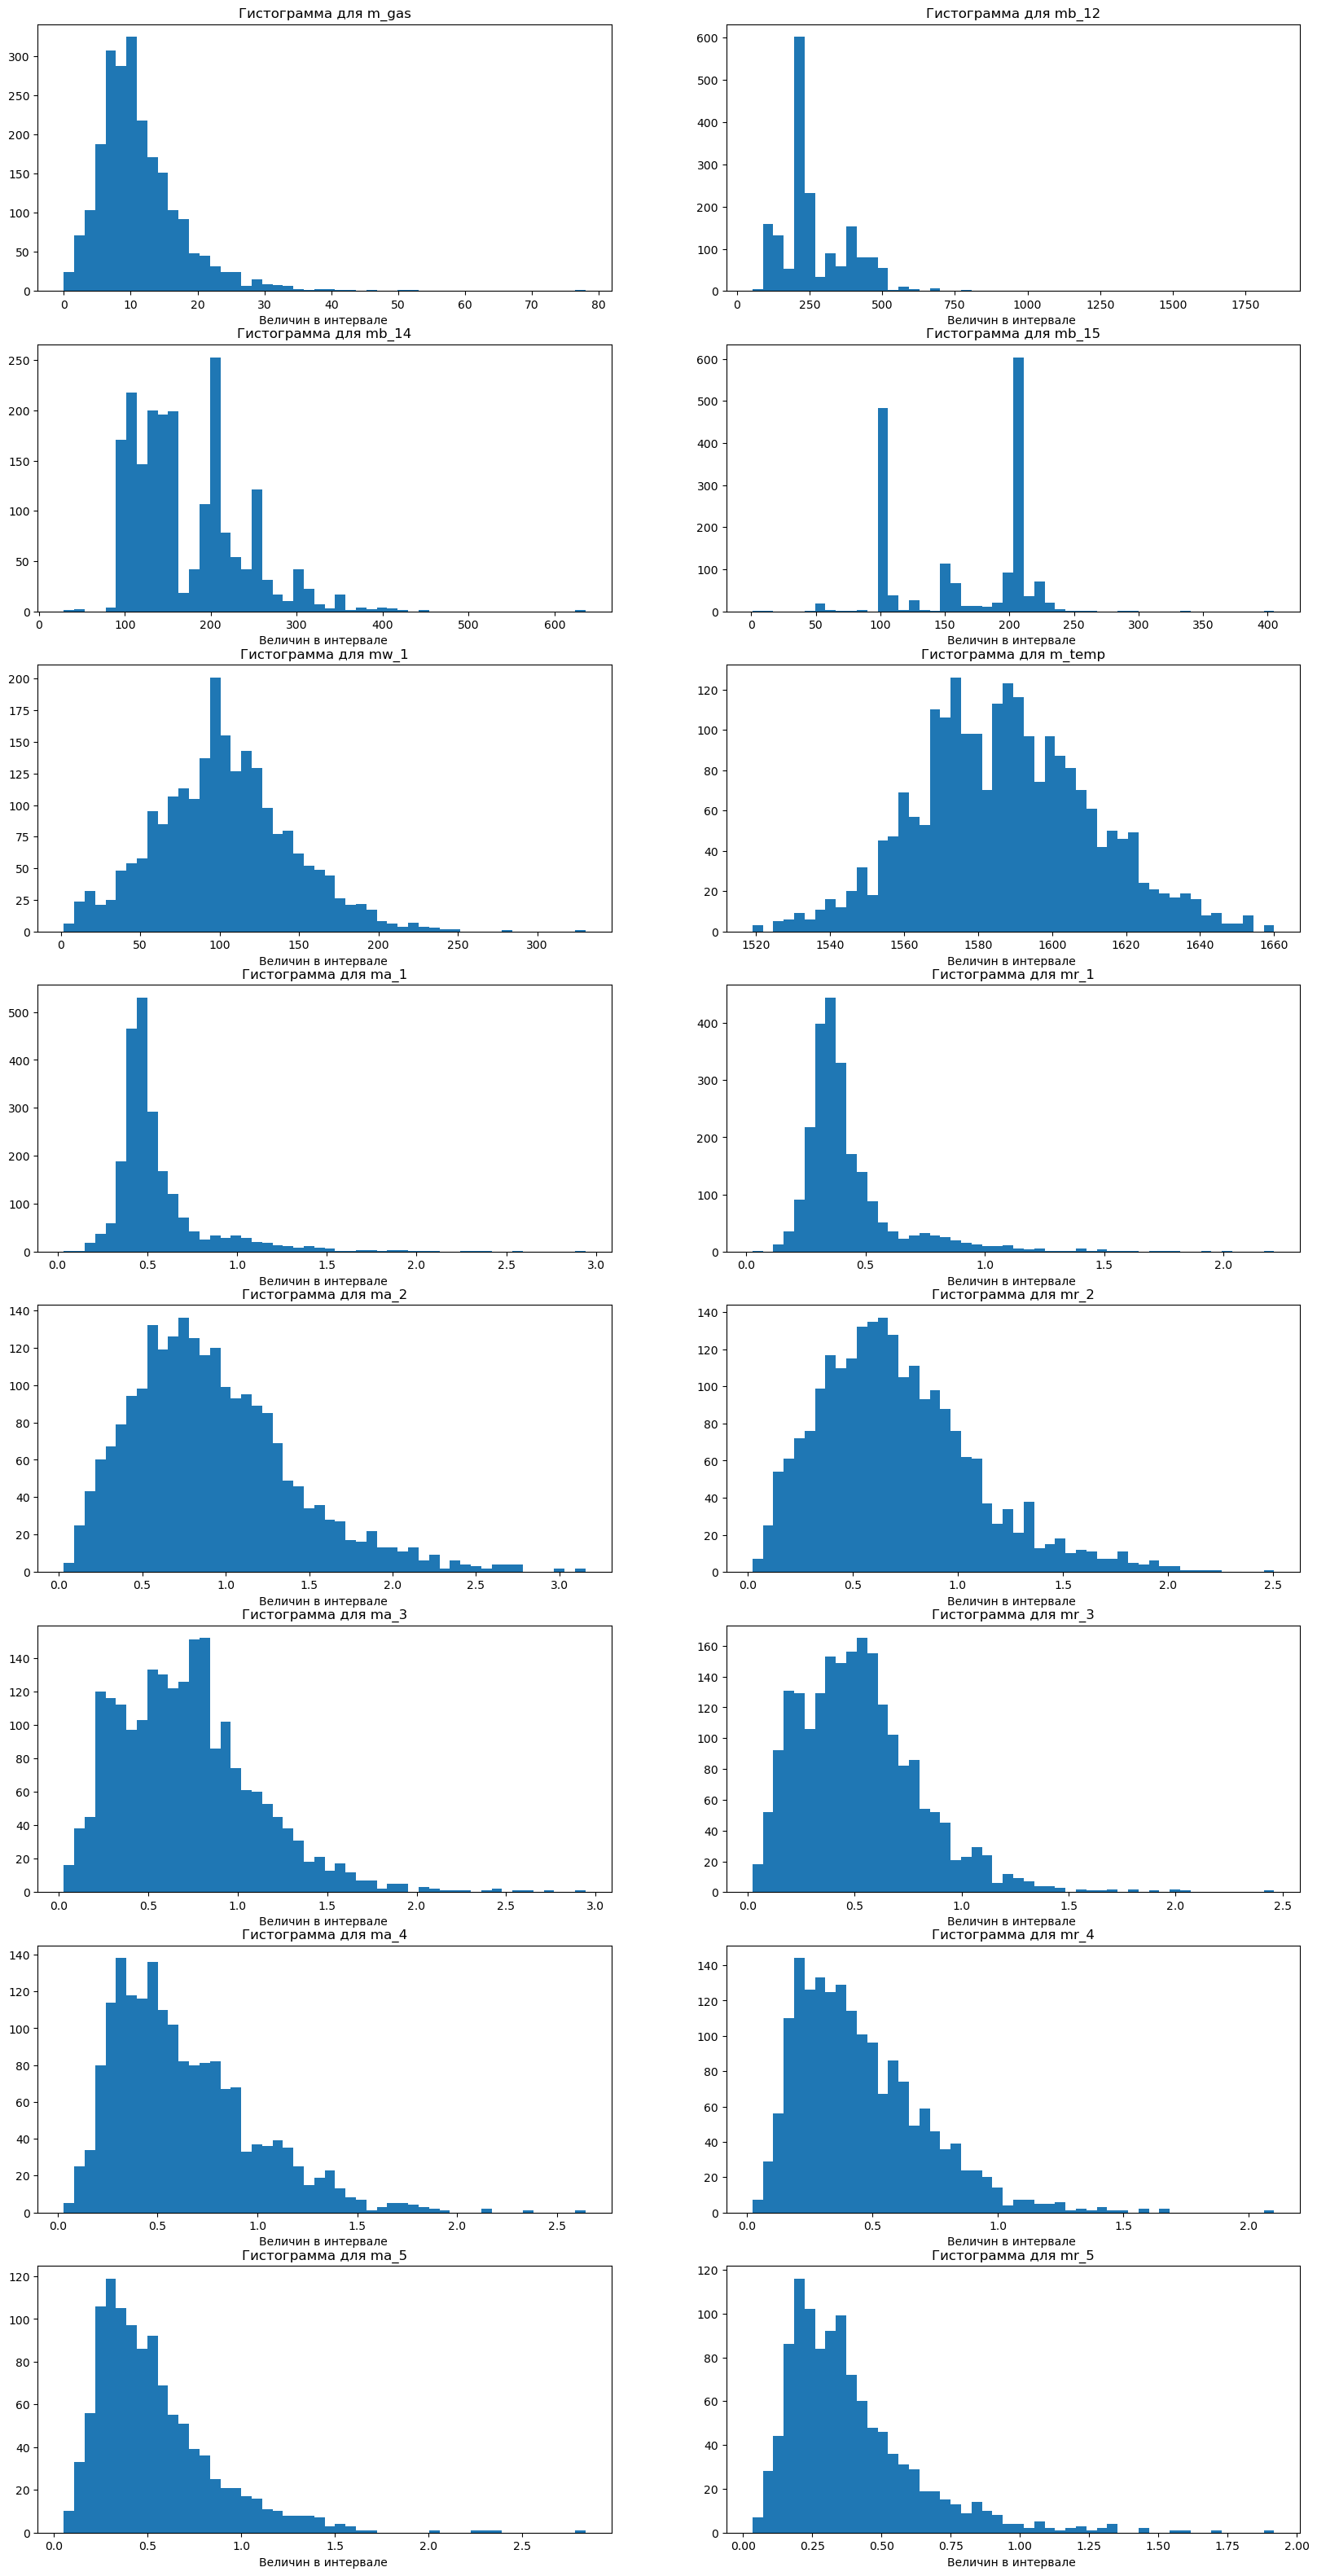

In [27]:
grid_rows = (len(magni1_cols)+1)//2
fig,axs = plt.subplots( grid_rows,2 , figsize=(20,5*grid_rows) )
for i in range(len(magni1_cols)):
    c = magni1_cols[i]           
    ax = axs[i//2,i%2]
    ax.hist(df[c],bins=50)
    ax.set_title(f'Гистограмма для {c}')
    ax.set_xlabel(f"Значения {c}, с интервалом 2% ")
    ax.set_xlabel(f"Величин в интервале ")
plt.show()

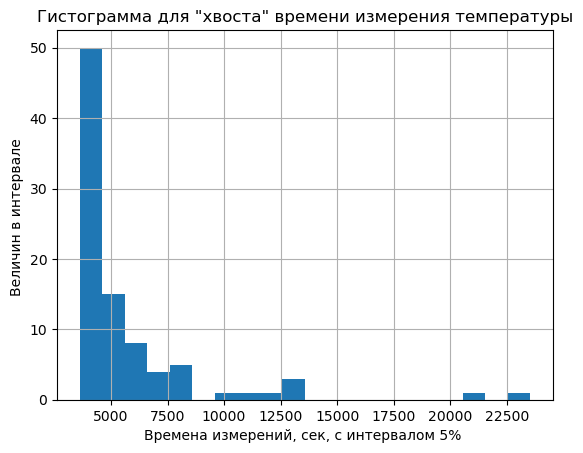

In [28]:
df[df.t_temp>3600].t_temp.hist(bins=20);
plt.title(f'Гистограмма для "хвоста" времени измерения температуры')
plt.xlabel(f"Времена измерений, сек, с интервалом 5% ")
plt.ylabel(f"Величин в интервале ")
plt.show()

Судя по гистограммам , сильные выбросы есть только для t_temp(время финального измерения температуры) и mb_12  
Выборка данных показывает, что это реальные процессы, а не сбой в данных и там согласованно меняются несколько параметров.
Корректировать их бессмысленно, и я не вижу оснований, чтобы уверенно их удалять.

In [29]:
df[df.mb_12>500][magni1_cols].sort_values(by='mb_12',ascending=False).head(30)

,m_gas,mb_12,mb_14,mb_15,mw_1,m_temp,ma_1,mr_1,ma_2,mr_2,ma_3,mr_3,ma_4,mr_4,ma_5,mr_5
279,77.995040,1849.0,636.0,NaN,NaN,1619.0,0.518544,0.382905,0.801966,0.582975,1.019583,0.815634,0.294657,0.212946,0.451133,0.363475
1826,7.815190,853.0,366.0,290.0,100.070877,1650.0,0.447065,0.382034,0.374652,0.351387,0.968894,0.859054,0.625355,0.476386,0.230362,0.157757
1656,23.488170,833.0,249.0,NaN,236.667587,1590.0,0.640420,0.426116,0.944198,0.646503,1.302291,1.014504,0.813074,0.565738,0.803872,0.678355
284,4.898431,775.0,403.0,205.0,97.016404,1572.0,0.427006,0.308683,1.169977,0.932679,1.139595,1.001114,0.790179,0.596116,0.744057,0.522543
1332,43.655411,774.0,306.0,100.0,280.987214,1567.0,0.567267,0.427851,1.892718,1.718930,0.916578,0.793427,NaN,NaN,NaN,NaN
1539,33.597044,733.0,248.0,224.0,187.153206,1583.0,0.337803,0.242150,1.230050,0.809881,1.211215,0.852895,0.857824,0.559878,0.605553,0.394115
2107,1.658822,685.0,199.0,206.0,45.077759,1541.0,0.533725,0.424341,2.668096,1.754383,1.179005,0.774032,0.777793,0.505913,NaN,NaN
388,28.482189,671.0,379.0,203.0,168.339600,1594.0,0.526707,0.346630,1.781754,1.510546,1.045433,0.878578,0.361857,0.292142,NaN,NaN
787,22.806671,669.0,102.0,NaN,185.561982,1591.0,0.482443,0.317078,1.489824,1.237689,0.462705,0.363727,0.765115,0.522780,0.602536,0.381190
899,3.807152,668.0,198.0,205.0,100.151993,1546.0,0.440596,0.332554,2.975003,2.006356,0.799800,0.511725,0.548441,0.361767,NaN,NaN


In [30]:
df[df.t_temp>7200][time1_cols].sort_values(by='t_temp',ascending=False)

,tb_12,tb_14,tb_15,tw_1,t_temp,th_1,te_1,th_2,te_2,th_3,te_3,th_4,te_4,th_5,te_5
1539,292.0,292.0,292.0,1021.0,23537.0,-167.0,-70.0,118.0,440.0,645.0,928.0,1363.0,1558.0,1852.0,1989.0
1927,NaN,NaN,NaN,20467.0,20923.0,-223.0,-88.0,1348.0,1435.0,1721.0,1776.0,1849.0,1909.0,2070.0,2188.0
574,-168.0,-168.0,-168.0,17.0,12789.0,-257.0,-49.0,32.0,168.0,998.0,1089.0,4254.0,4379.0,4435.0,5048.0
716,99.0,99.0,11493.0,12197.0,12753.0,-197.0,-100.0,15.0,319.0,363.0,569.0,11061.0,11172.0,11311.0,11650.0
1717,178.0,178.0,178.0,424.0,12643.0,-282.0,-118.0,154.0,238.0,595.0,814.0,1258.0,1661.0,10555.0,10734.0
1716,1699.0,172.0,1699.0,407.0,11819.0,-194.0,-49.0,164.0,362.0,523.0,633.0,1015.0,1195.0,1320.0,1399.0
1380,188.0,188.0,188.0,465.0,10954.0,-390.0,-279.0,92.0,379.0,549.0,682.0,825.0,930.0,1179.0,1251.0
93,NaN,NaN,NaN,NaN,9598.0,-593.0,-358.0,769.0,838.0,1737.0,1796.0,7993.0,8244.0,8616.0,9253.0
1926,NaN,NaN,NaN,3456.0,8194.0,-189.0,-56.0,1553.0,1636.0,1914.0,2083.0,3083.0,3258.0,3337.0,3395.0
1145,NaN,240.0,240.0,443.0,7743.0,-179.0,-55.0,193.0,329.0,4786.0,4894.0,4996.0,5067.0,5198.0,5410.0


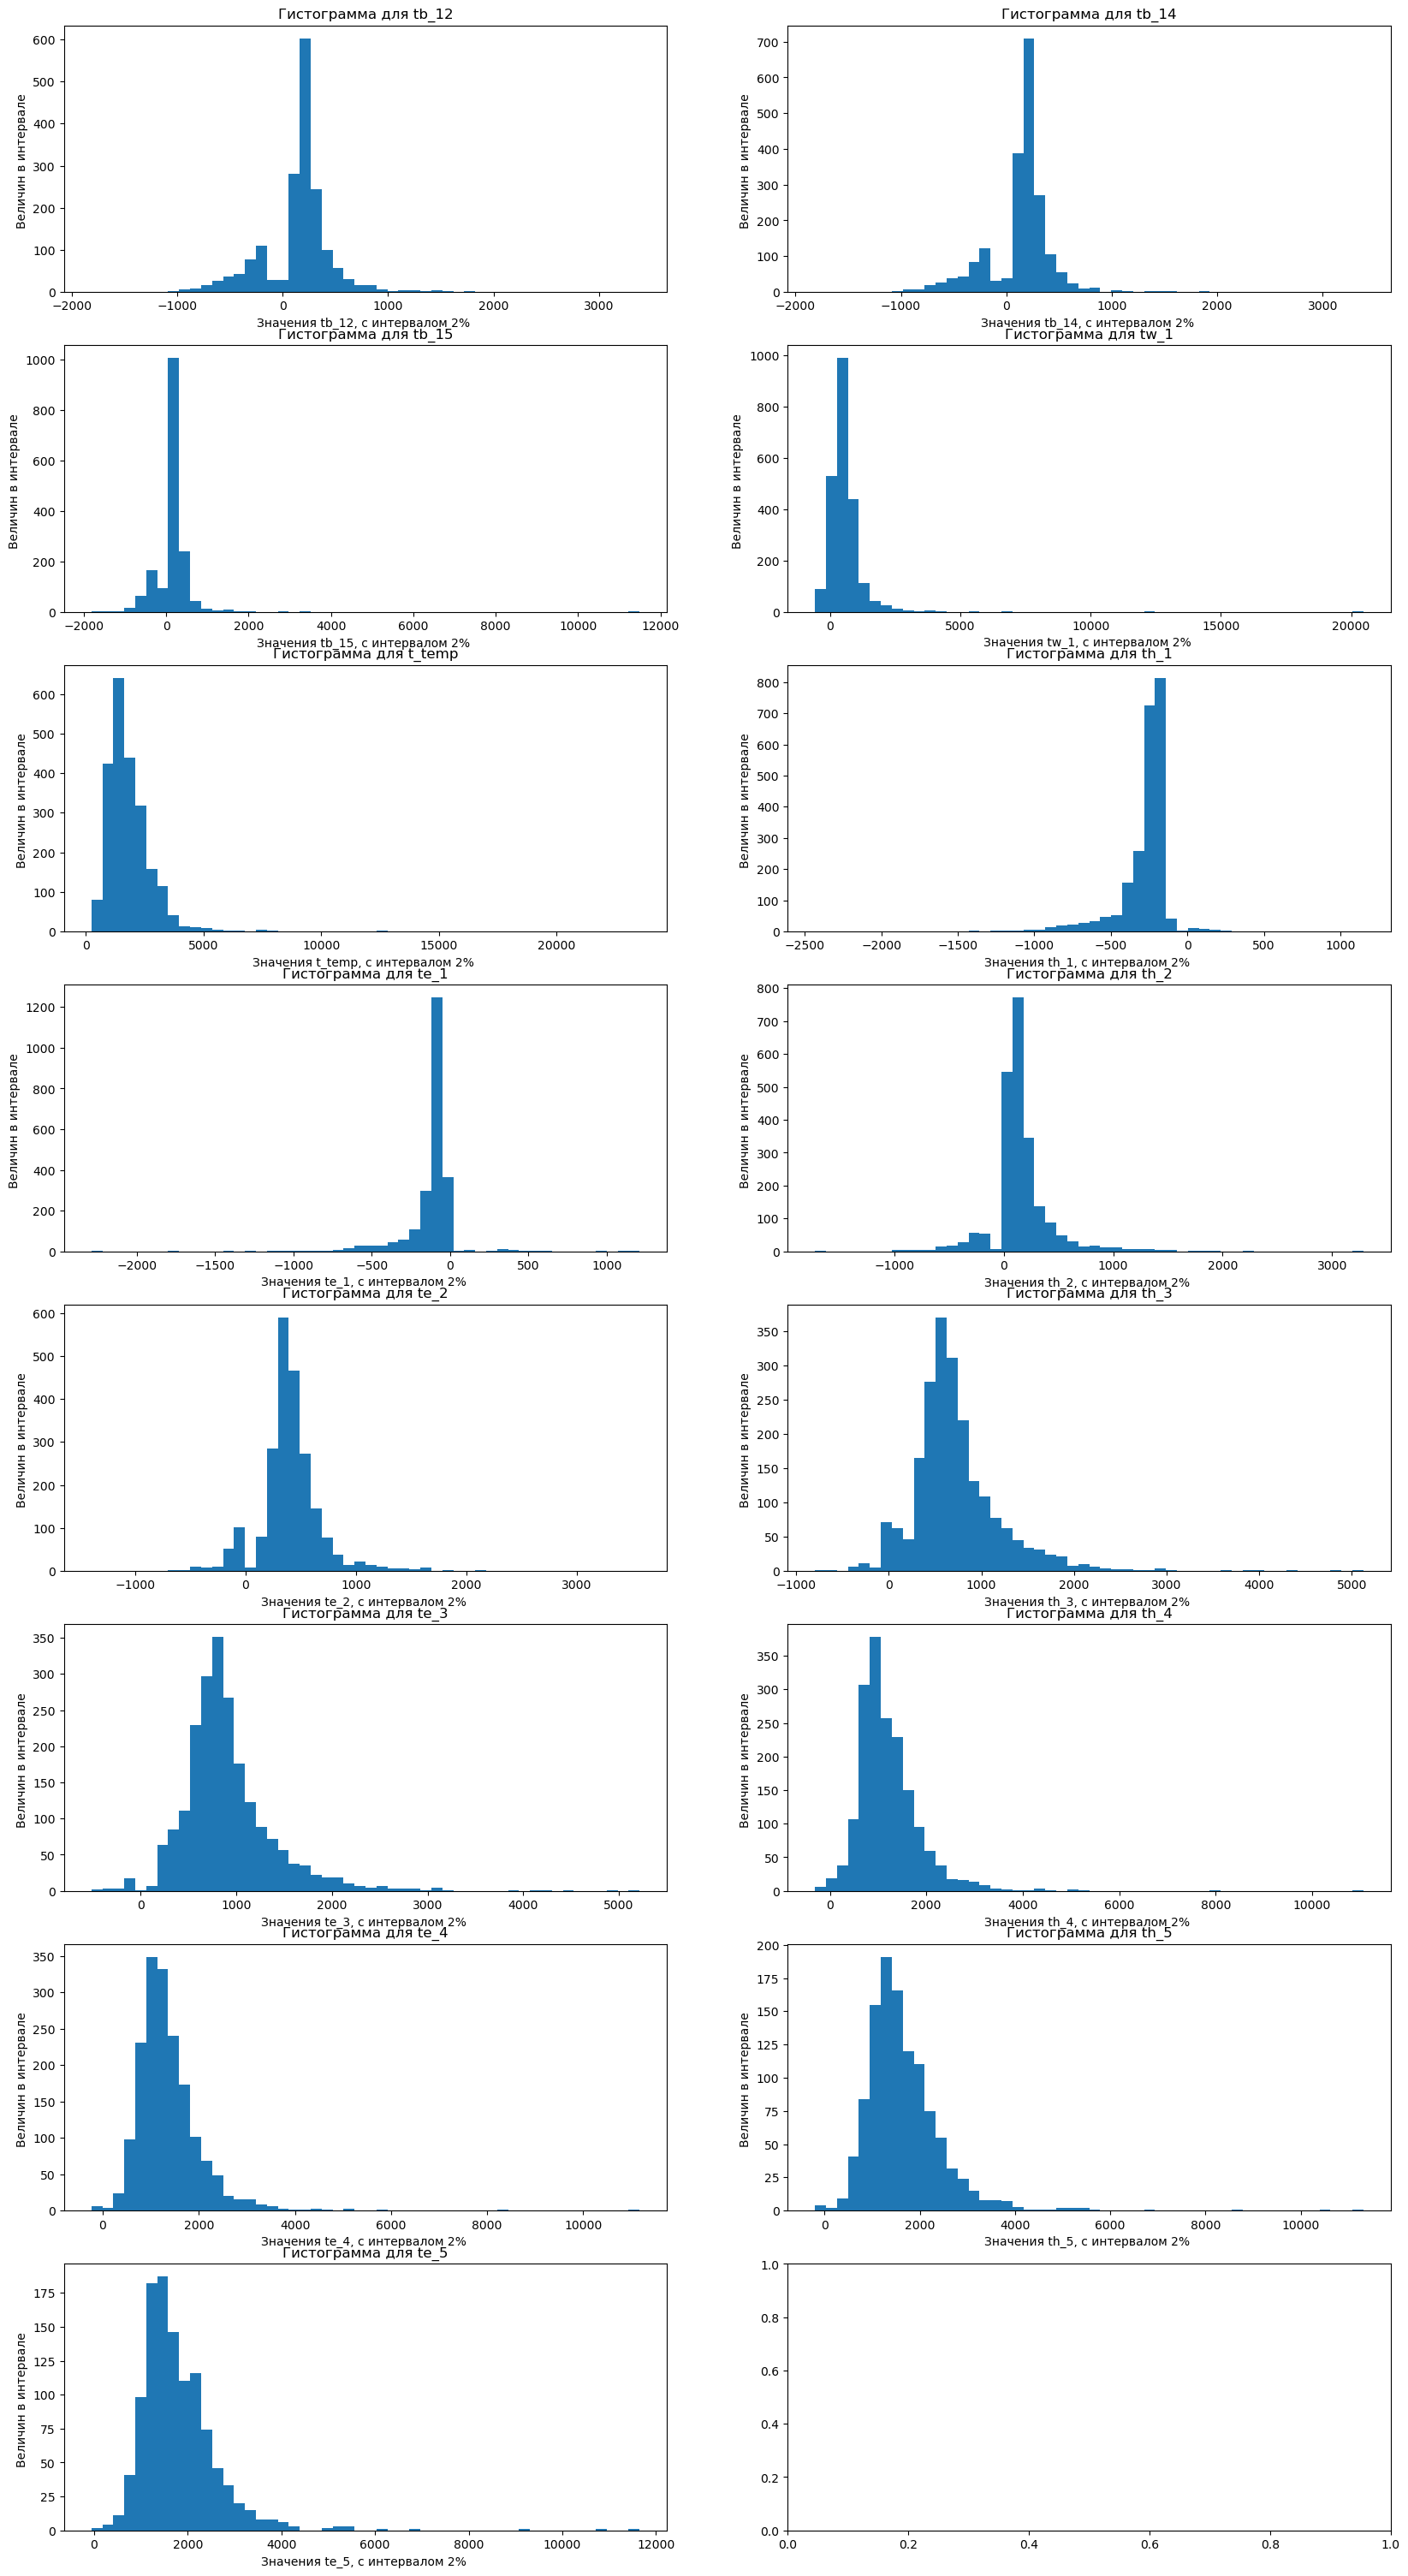

In [31]:
fig,axs = plt.subplots( len(time1_cols)//2+1,2 , figsize=(20,5*len(time1_cols)//2+1) )
for i in range(len(time1_cols)):
    c = time1_cols[i]           
    ax = axs[i//2,i%2]
    ax.hist(df[c],bins=50)
    ax.set_title(f'Гистограмма для {c}')
    ax.set_xlabel(f"Значения {c}, с интервалом 2% ")
    ax.set_ylabel(f"Величин в интервале ")
plt.show()

#### Корреляции

Между параметрами добавок есть довольно сильные корреляции до 0.8   
Но так как это редко используемые параметры и они влияют в основном на сходимость , а не на метрику, я  

In [32]:
df[bulk_cols+['y_temp']].corr()

,mb_1,mb_2,mb_3,mb_4,mb_5,mb_6,mb_7,mb_8,mb_9,mb_10,mb_11,mb_12,mb_13,mb_14,mb_15,y_temp
mb_1,1.000000,-0.224102,-0.044454,-0.074592,-0.725832,-0.035631,-0.292932,NaN,NaN,-0.278055,0.709720,0.378232,NaN,0.397649,-0.048213,-0.131480
mb_2,-0.224102,1.000000,NaN,0.248113,0.318419,NaN,-0.020662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.119695
mb_3,-0.044454,NaN,1.000000,-0.242485,0.108888,0.192361,NaN,NaN,0.718514,-0.309049,0.213127,0.024875,-0.123402,0.001735,-0.011942,-0.010241
mb_4,-0.074592,0.248113,-0.242485,1.000000,-0.047283,-0.631326,0.580517,NaN,0.789128,-0.510301,NaN,0.057151,-0.666038,0.028190,0.011940,0.022055
mb_5,-0.725832,0.318419,0.108888,-0.047283,1.000000,-0.623686,0.496361,NaN,NaN,NaN,NaN,0.013130,NaN,-0.307588,-0.327260,0.117259
mb_6,-0.035631,NaN,0.192361,-0.631326,-0.623686,1.000000,NaN,NaN,NaN,NaN,-0.085136,-0.021797,0.835761,0.172482,-0.004061,0.084699
mb_7,-0.292932,-0.020662,NaN,0.580517,0.496361,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,0.433107
mb_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mb_9,NaN,NaN,0.718514,0.789128,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.972966,NaN,-0.945834,NaN,-0.324501
mb_10,-0.278055,NaN,-0.309049,-0.510301,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.014606,NaN,-0.239197,0.131225,0.070748


In [33]:
df[wire_cols+['y_temp']].corr()

,mw_1,mw_2,mw_3,mw_4,mw_5,mw_6,mw_7,mw_8,mw_9,y_temp
mw_1,1.000000,-0.037159,0.713613,0.209760,NaN,-0.361721,0.200922,0.206294,0.019905,0.311355
mw_2,-0.037159,1.000000,-0.064053,NaN,NaN,-1.000000,NaN,0.243614,0.085986,-0.180693
mw_3,0.713613,-0.064053,1.000000,0.153150,NaN,-0.351749,0.224086,NaN,NaN,0.055285
mw_4,0.209760,NaN,0.153150,1.000000,NaN,0.252131,0.382860,NaN,NaN,-0.621452
mw_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mw_6,-0.361721,-1.000000,-0.351749,0.252131,NaN,1.000000,0.408053,NaN,NaN,-0.229815
mw_7,0.200922,NaN,0.224086,0.382860,NaN,0.408053,1.000000,NaN,NaN,-0.399870
mw_8,0.206294,0.243614,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.077524
mw_9,0.019905,0.085986,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.133361
y_temp,0.311355,-0.180693,0.055285,-0.621452,NaN,-0.229815,-0.399870,0.077524,-0.133361,1.000000


In [34]:
df[tier1_cols+['y_temp']].corr().head(60)

,m_gas,mb_12,mb_14,mb_15,mw_1,m_temp,ma_1,mr_1,ma_2,mr_2,...,te_1,th_2,te_2,th_3,te_3,th_4,te_4,th_5,te_5,y_temp
m_gas,1.000000,0.235404,0.311619,-0.047876,0.151094,0.044905,-0.010363,-0.026622,0.131844,0.136817,...,-0.050212,0.048106,0.110996,0.202415,0.220384,0.248736,0.258997,0.297936,0.303657,0.061917
mb_12,0.235404,1.000000,0.470607,0.408189,0.190645,-0.040763,0.057061,0.075517,0.283524,0.309910,...,0.016050,-0.007519,0.128062,0.088666,0.127905,0.114840,0.139027,0.177081,0.189367,0.230387
mb_14,0.311619,0.470607,1.000000,0.107855,-0.046874,-0.140409,0.055351,0.041917,0.222680,0.216731,...,-0.119786,-0.133448,-0.018692,0.003745,0.039488,0.039139,0.057905,0.057744,0.069628,0.062651
mb_15,-0.047876,0.408189,0.107855,1.000000,0.062116,-0.059439,0.145250,0.158808,0.185125,0.181515,...,0.053817,-0.046939,0.025297,-0.011763,0.011969,0.028107,0.039584,0.137383,0.143192,0.162909
mw_1,0.151094,0.190645,-0.046874,0.062116,1.000000,0.280713,-0.075425,-0.097184,-0.100083,-0.092265,...,0.054560,0.171062,0.135531,0.148087,0.153967,0.130587,0.130993,0.100722,0.102126,0.311355
m_temp,0.044905,-0.040763,-0.140409,-0.059439,0.280713,1.000000,-0.189383,-0.217996,-0.360425,-0.325431,...,0.078686,0.400888,0.278960,0.430819,0.383015,0.439628,0.412205,0.419620,0.405911,0.303125
ma_1,-0.010363,0.057061,0.055351,0.145250,-0.075425,-0.189383,1.000000,0.976767,-0.073814,-0.130664,...,-0.052795,-0.121397,-0.177252,-0.188810,-0.184263,-0.190086,-0.195994,-0.142509,-0.140846,-0.005793
mr_1,-0.026622,0.075517,0.041917,0.158808,-0.097184,-0.217996,0.976767,1.000000,-0.053418,-0.089153,...,-0.041076,-0.121648,-0.169521,-0.193797,-0.187352,-0.193411,-0.197236,-0.147519,-0.144439,-0.012947
ma_2,0.131844,0.283524,0.222680,0.185125,-0.100083,-0.360425,-0.073814,-0.053418,1.000000,0.972414,...,0.001997,-0.187484,0.209985,0.133065,0.158952,0.142360,0.157354,0.154215,0.149964,0.175685
mr_2,0.136817,0.309910,0.216731,0.181515,-0.092265,-0.325431,-0.130664,-0.089153,0.972414,1.000000,...,0.018922,-0.160904,0.236279,0.163133,0.190479,0.165630,0.183148,0.173457,0.170164,0.163681


Параметров много, единственная замеченная корреляция - между активной и реактивной мощностью.  
Так как полная мощность - корень из суммы квадратов этих мощностей, я предполагаю, что будет полезно нелинейное преобразование   
в полную мощность + коэффициент показывающий их расхождение (насколько помню, обычно используют косинус угла между вектором полной мощности и осью абсцисс)  

#### Порядок операций

код ниже проверяет , сответствует ли порядок номеров колонок порядку операций при загрузке/плавках  

In [35]:
def is_not_sorted(di):
    din = [ v for v in di[di.notna()].values if v is not None]
    return not (din==sorted(din))
print( 'Нарушений при добавках ',df[bulk_time_cols].apply(is_not_sorted,axis=1).sum() )
print( 'Нарушений при добавках проволоки',df[wire_time_cols].apply(is_not_sorted,axis=1).sum() )
print( 'Нарушений при начале плавок',df[begin_heat_cols].apply(is_not_sorted,axis=1).sum() )
print( 'Нарушений при конце плавок',df[end_heat_cols].apply(is_not_sorted,axis=1).sum() )

Нарушений при добавках  1759
Нарушений при добавках проволоки 44
Нарушений при начале плавок 4
Нарушений при конце плавок 4


In [36]:
df[df[begin_heat_cols].apply(is_not_sorted,axis=1)][['begin_time','t_temp']+begin_heat_cols]

,begin_time,t_temp,th_1,th_2,th_3,th_4,th_5,th_6,th_7,th_8,th_9,th_10,th_11,th_12,th_13,th_14,th_15
1001,00:06:55,331.0,-240.0,10.0,-747.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1398,00:01:58,1739.0,79.0,840.0,1454.0,-259.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1427,00:01:08,1939.0,91.0,498.0,969.0,1329.0,-193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1584,00:01:48,974.0,48.0,605.0,720.0,-268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df[df[end_heat_cols].apply(is_not_sorted,axis=1) ][['t_temp']+end_heat_cols]

,t_temp,te_1,te_2,te_3,te_4,te_5,te_6,te_7,te_8,te_9,te_10,te_11,te_12,te_13,te_14,te_15
1001,331.0,-97.0,236.0,-417.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1398,1739.0,631.0,970.0,1641.0,-122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1427,1939.0,359.0,752.0,1096.0,1534.0,-55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1584,974.0,237.0,666.0,753.0,-121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Моделирование

#### Заполнение пустых значений

Пропуски операций естественно заполнить нулями

In [38]:
df= df.fillna(0)

#### Разбиение данных

Разбиваем данные на тренироваочный и тестовый наборы с параметрами,  указанными в требованиях к проекту.
Выделение валидационных наборов производится в процедурах кроссвалидации 

In [39]:
y = 'y_temp'
X = (magni_cols + time_cols+ int_cols)


In [40]:
df_tr, df_te = train_test_split(df, test_size=.25, shuffle=True, random_state=RANDOM_STATE)

### Обучение моделей

 В заданни проекта есть рекомендации по созданию дополнительных признаков,  
 чтобы проверить насколько они полезны, я написал небольшой трансформер, который умеет выполнять две задачи:
 - объединять активную и реактивную мощность полную и выделять косинус угла между акивной и реактивной
 - объединять все павки в интегральную с общими мощностями и средними временами начала и конца (желательно среднее время начала и средняя продолжительность, но это линейные операции и на модели влиять не должны)
 - и кроме того может ничего не менять  ( dummy_transformer)
 Как я понимаю, после трансформации оригинальные признаки нужно удалять, чтобы не получить корреляцию

In [41]:
def dummy_transformer(X):
    Xc = X.copy()
    return Xc

def full_power_transformer(X):
    func0 = lambda a,b: np.sqrt(np.power( a,2) + np.power(b,2) )
    func1 = lambda a,b: np.divide(a, func0(a,b), out=np.zeros_like(a), where=b!=0)
    Xc = X.copy()
    for i in range(1,15): 
        Xc[f"ma_{i}"] = func0(X[f"ma_{i}"],X[f"mr_{i}"]) # * (X[f"te_{i}"]-X[f"th_{i}"]) 
        Xc[f"mr_{i}"] = func1(X[f"ma_{i}"],X[f"mr_{i}"])        
    return Xc

def agg_transformer(X):
    Xc = X.copy()
    act_cols = [c for c in X.columns if c[:2]=='ma' ]
    react_cols = [c for c in X.columns if c[:2]=='mr' ]
    begin_cols = [c for c in X.columns if c[:2]=='th' ]
    end_cols = [c for c in X.columns if c[:2]=='te' ]    
    copy_cols = [c for c in X.columns if c not in act_cols + react_cols + begin_cols + end_cols  ]
    agg  ={}
    avg = lambda subframe: (subframe.sum(axis=1)/(subframe>0).astype(int).sum(axis=1)).replace((np.inf, -np.inf),(0,0))
    agg['th'] = avg(X[begin_cols])
    agg['te'] = avg(X[end_cols])
    agg['ma'] = X[act_cols].sum(axis=1)
    agg['mr'] = X[react_cols].sum(axis=1)

    Xc =  pd.concat([ Xc[copy_cols], pd.DataFrame(agg)] , axis=1)

    return(Xc)

class PowerTransformer(BaseEstimator, TransformerMixin):
    transformers = {
        'dummy': dummy_transformer,
        'full_power': full_power_transformer,
        'agg' : agg_transformer 
    }
                     
    def __init__(self,tf_name = 'dummy'):
        super().__init__()
        self.tf_name = tf_name
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        try:
            func= self.transformers[self.tf_name]
        except Exception as e:
            print('Failed to find transformer by name:',e)
        return func(X)

Проверим последовательно различные модели

### Линейная регрессия

In [43]:
%%time
power_tf = PowerTransformer()
scaler = StandardScaler()
model= SGDRegressor(max_iter =100_000)
scoring=['neg_mean_absolute_error','r2']
refit = scoring[0]

params_grid = {
    'pow__tf_name': ['dummy','full_power','agg'],
    'mod__penalty': ['l2','l1'],
    'mod__eta0':[.01,.003,.001,3e-4,1e-4]
}

pipe = Pipeline( [['pow', power_tf],['sca',scaler],['mod',model]])
lin_gcv = GridSearchCV(pipe,params_grid,cv =4,scoring=scoring,refit=refit)
lin_res = lin_gcv.fit(df_tr[X],df_tr[y])
lin_gcv.best_score_,lin_gcv.best_params_

CPU times: user 26.4 s, sys: 3.19 ms, total: 26.4 s
Wall time: 26.4 s


(-5.4571852775339655,
 {'mod__eta0': 0.001, 'mod__penalty': 'l1', 'pow__tf_name': 'dummy'})

In [44]:
y_pr = lin_gcv.best_estimator_.predict(df_te[X])
print_metrics(df_te[y],y_pr)

mean_absolute_error: 5.592770096939283 
RMSE: 7.713099023049118 
r2_score: 0.5659472689698023 


{'mean_absolute_error': 5.592770096939283,
 'RMSE': 7.713099023049118,
 'r2_score': 0.5659472689698023}

In [45]:
lin_res = lin_gcv.cv_results_
lin_res

{'mean_fit_time': array([0.00888002, 0.02032036, 0.01184535, 0.00836951, 0.01867729,
        0.01338458, 0.00722092, 0.01725388, 0.03321844, 0.0083831 ,
        0.01903701, 0.08096015, 0.13645744, 0.14064938, 0.115834  ,
        0.2457425 , 0.28654152, 0.18555135, 0.25919431, 0.22047406,
        0.19831473, 0.44809568, 0.36304885, 0.30909663, 0.42411405,
        0.42045456, 0.2819429 , 0.75826675, 0.75171626, 0.47223711]),
 'std_fit_time': array([0.00066686, 0.00374876, 0.00050323, 0.0004761 , 0.0005962 ,
        0.00231073, 0.00047428, 0.00045712, 0.00508004, 0.00023977,
        0.00052577, 0.04341322, 0.02486728, 0.03823537, 0.00677112,
        0.04833369, 0.06087157, 0.01300088, 0.0403103 , 0.01487406,
        0.01886847, 0.04319688, 0.02600878, 0.08383336, 0.01082536,
        0.0118193 , 0.00606794, 0.01549666, 0.00651836, 0.01503797]),
 'mean_score_time': array([0.00290966, 0.01220065, 0.00766397, 0.00228983, 0.01279181,
        0.00711793, 0.00211376, 0.01216054, 0.00764507, 0.00

In [46]:
lin_pars = ParsedResult(lin_res,metric_name='neg_mean_absolute_error')
idx = pd.IndexSlice
lin_sel = lin_pars.select('mod__eta0')
lin_sel

mean_test_neg_mean_absolute_error                              \
pow__tf_name                               agg                       dummy   
mod__penalty                                l1            l2            l1   
mod__eta0                                                                    
0.0001                               -5.796422     -5.791415 -5.620802e+00   
0.0003                               -5.690219     -5.679005 -5.492193e+00   
0.001                                -5.611357     -5.621640 -5.457185e+00   
0.003                                -5.627671     -5.727286 -3.823735e+07   
0.01                             -17421.999235 -83718.388727 -8.565231e+10   

                                                        
pow__tf_name                  full_power                
mod__penalty            l2            l1            l2  
mod__eta0                                               
0.0001       -5.624784e+00 -5.715383e+00 -5.707867e+00  
0.0003       -5.502210e+00 -5.667621e+00 -5.673675e+00  
0.001        -5.523590e+00 -5.659595e+00 -5.660881e+00  
0.003        -6.623933e+07 -4.352124e+07 -5.436320e+07  
0.01         -3.710231e+10 -9.113023e+10 -3.819194e+10

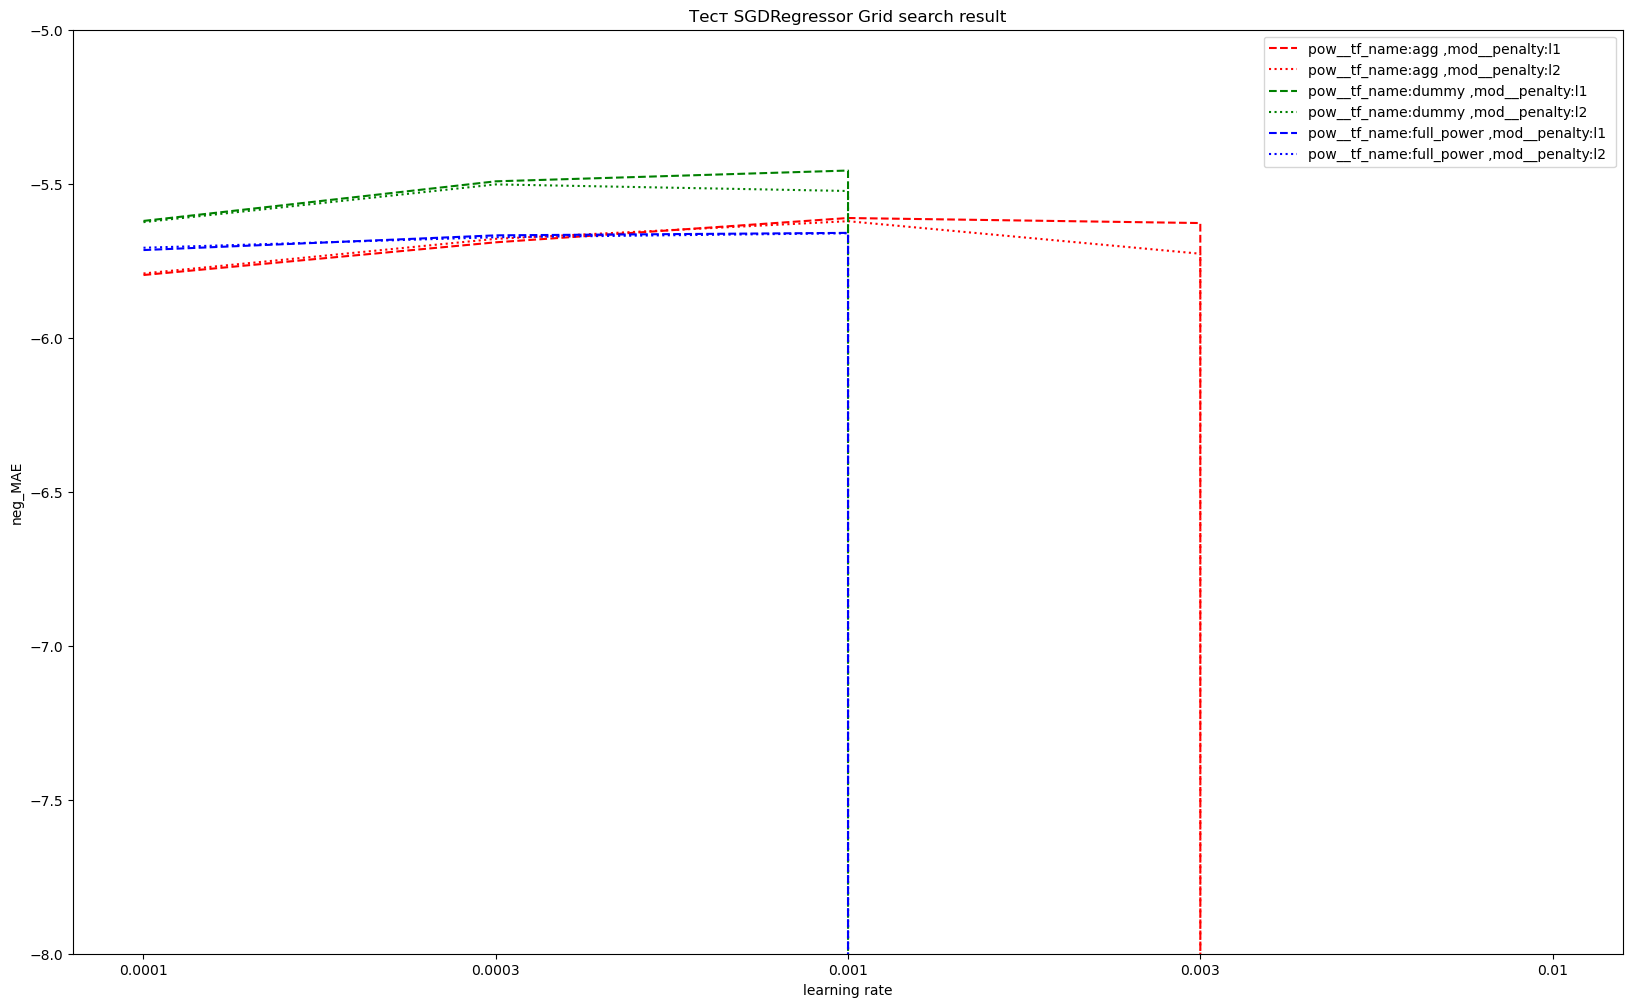

In [47]:
ResultPlotter(lin_sel,{'title':'SGDRegressor Grid search result','metric':'neg_MAE'}).plot()
plt.ylim(-8,-5);
plt.show()

Модель SGDRegressor показывает работает быстро , показывает хороший результат при eta= 0.0001 - 0.003  
Транформеры немного ухудшают метрику MAE на 0.01-0.02
Метрика резко падает при приближении скорости eta к дефолтным  0.01 .  
Лучшая метрика на кроссвалидации <b>MAE = 5.48</b>  
И так как эта модель по результатам кроссвалидации выбрана для финального тестирования, сразу укажу здесь его результат  

<b><u>MAE = 5.6</u></b>

### Light Gradient Boosting

In [48]:
%%time
power_tf = PowerTransformer()
scaler = StandardScaler()
model = lgb.LGBMRegressor(verbose = -1,random_state=RANDOM_STATE)
scoring=['neg_mean_absolute_error','r2']
refit = scoring[0]

params_grid = {
    'pow__tf_name': ['dummy','full_power','agg'],
    'mod__learning_rate': [.3,.1,.03,.01,.003],
    'mod__n_estimators':[1024],
    'mod__boosting' :['gbdt','dart'],
    'mod__max_depth':  [32],#[32,128,1024],
    'mod__num_leaves': [512]       
}

pipe = Pipeline( [['pow', power_tf],['sca',scaler],['mod',model]])
lgb_gcv = GridSearchCV(pipe,params_grid,cv =4,scoring=scoring,refit=refit)
lgb_res = lgb_gcv.fit(df_tr[X],df_tr[y])
lgb_gcv.best_score_,lgb_gcv.best_params_

CPU times: user 8min 34s, sys: 181 ms, total: 8min 34s
Wall time: 8min 34s


(-5.656058021217195,
 {'mod__boosting': 'gbdt',
  'mod__learning_rate': 0.01,
  'mod__max_depth': 32,
  'mod__n_estimators': 1024,
  'mod__num_leaves': 512,
  'pow__tf_name': 'agg'})

In [49]:
y_pr = lgb_gcv.best_estimator_.predict(df_te[X])
print_metrics(df_te[y],y_pr)

mean_absolute_error: 5.550955838072563 
RMSE: 8.009682983031547 
r2_score: 0.5319251207930125 


{'mean_absolute_error': 5.550955838072563,
 'RMSE': 8.009682983031547,
 'r2_score': 0.5319251207930125}

In [50]:
lgb_res = lgb_gcv.cv_results_
lgb_res

{'mean_fit_time': array([2.81128007, 2.762685  , 1.47995925, 2.87438565, 2.88364816,
        1.41595954, 2.4972952 , 2.48603284, 1.38297391, 2.36923283,
        2.33966649, 1.3277297 , 2.26153815, 2.34711957, 1.23569852,
        5.99561095, 6.01963872, 4.72468704, 5.85613388, 5.65675497,
        4.71940821, 6.41202503, 8.2892257 , 8.75829637, 6.67192531,
        9.43810248, 4.77284199, 5.91185784, 6.13324666, 4.54861325]),
 'std_fit_time': array([0.18356469, 0.12910759, 0.10122668, 0.22680429, 0.17285404,
        0.03458908, 0.04369069, 0.01179905, 0.06660495, 0.05769913,
        0.01807689, 0.05311301, 0.02294722, 0.09855057, 0.00363332,
        0.09297484, 0.16009474, 0.0423741 , 0.34852694, 0.02548944,
        0.22037908, 0.34816986, 1.24572809, 3.27743497, 0.7071667 ,
        1.42451626, 0.04382903, 0.1063904 , 0.14425183, 0.08845326]),
 'mean_score_time': array([0.05711085, 0.07210147, 0.0616827 , 0.06000918, 0.06930363,
        0.06327415, 0.05172747, 0.06123924, 0.0605247 , 0.04

In [51]:
lgb_pars = ParsedResult(lgb_res,metric_name='neg_mean_absolute_error')
idx = pd.IndexSlice
#print( lgb_pars.select('mod__learning_rate').loc[:,idx[:,:,['dart']]] )
lgb_sel = lgb_pars.select('mod__learning_rate')#.loc[:,idx[:,:,'gbdt']] 
lgb_sel

mean_test_neg_mean_absolute_error                        \
pow__tf_name                                     agg                 dummy   
mod__boosting                                   dart      gbdt        dart   
mod__learning_rate                                                           
0.003                                    -708.527629 -5.670068 -708.552106   
0.01                                     -282.137760 -5.656058 -282.185956   
0.03                                      -94.774406 -5.697709  -94.844402   
0.1                                       -22.956407 -5.773600  -23.047822   
0.3                                        -6.647922 -6.104812   -6.639156   

                                                    
pow__tf_name                  full_power            
mod__boosting           gbdt        dart      gbdt  
mod__learning_rate                                  
0.003              -6.037934 -708.571637 -6.009071  
0.01               -5.780924 -282.221215 -5.744118  
0.03               -5.742890  -94.883001 -5.767131  
0.1                -5.846295  -23.025910 -5.830229  
0.3                -6.056170   -6.640022 -6.163930

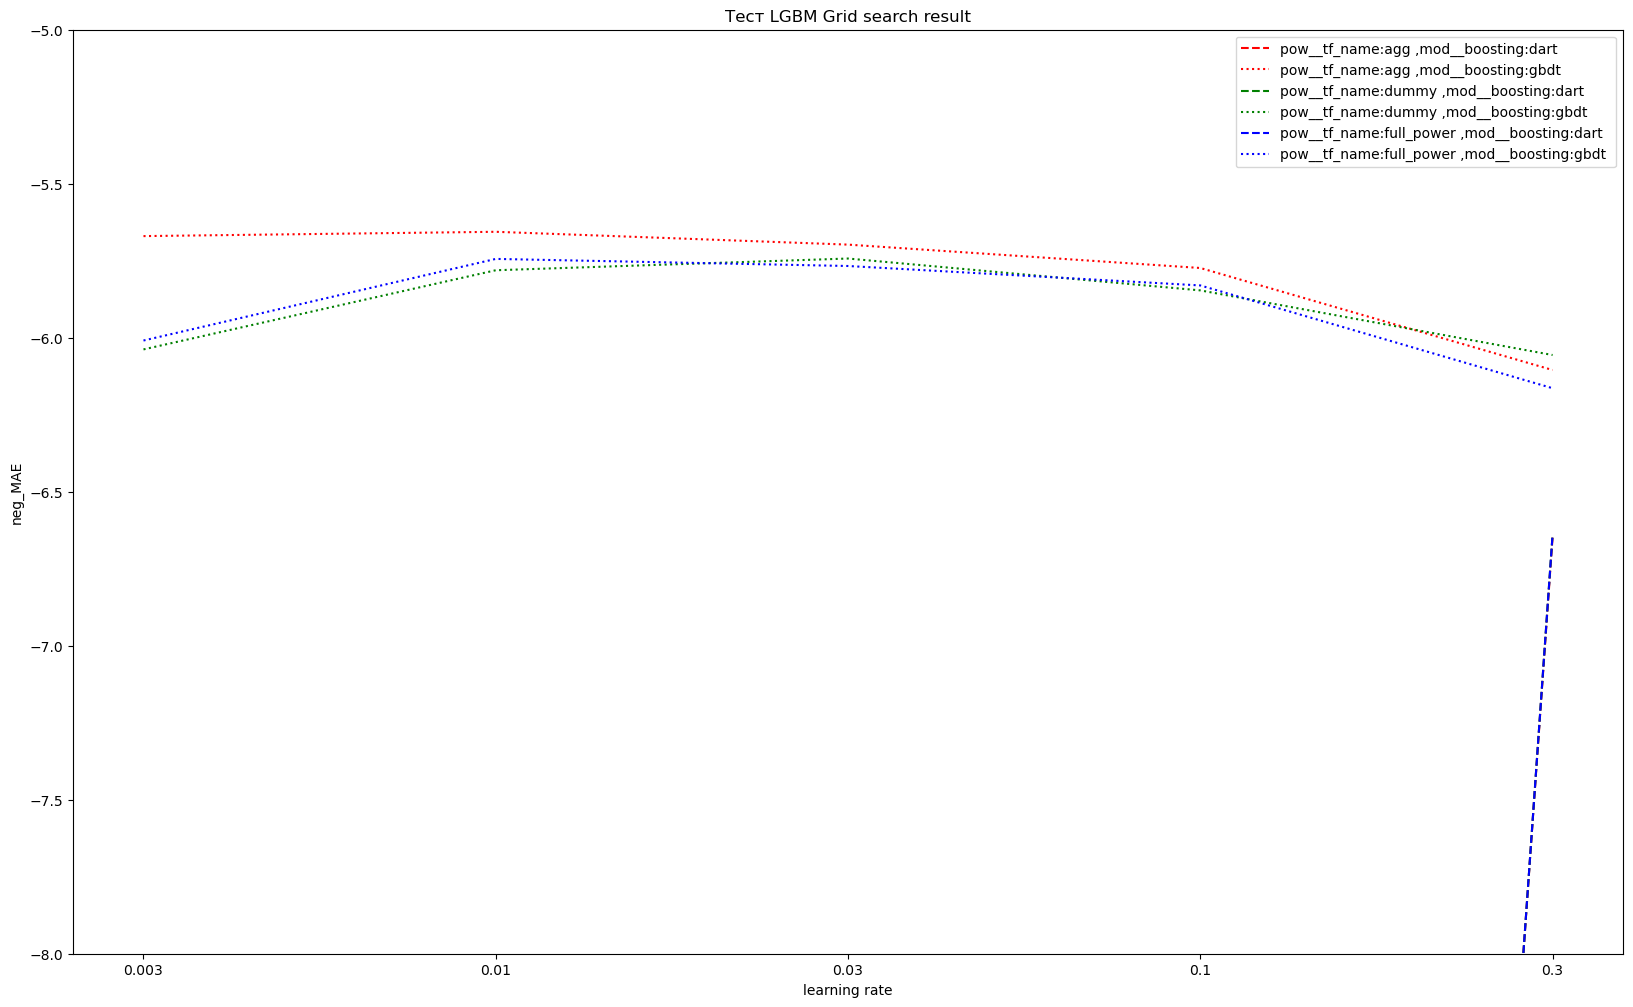

In [52]:
ResultPlotter(lgb_sel,{'title':'LGBM Grid search result','metric':'neg_MAE'}).plot()
plt.ylim(-8,-5);
plt.show()

Результат довольно нестабилен, особенно при бустинге dart.  
В целом, модель не показала преимуществ перед SGD Regressor, но работает значительно медленнее.   
Как и в линейной модели, предварительные трансформеры не сильно влияют на результат, но эффективность обратная - лучше всего показал себя аггрегатор плавок, хуже всего - тривиальный трансформер.    
Лучшая метрика на кроссвалидации <b>MAE = 5.65</b>

### RandomForest

In [53]:
%%time
power_tf = PowerTransformer()
scaler = StandardScaler()
model = lgb.LGBMRegressor(verbose = -1,random_state=RANDOM_STATE)
scoring=['neg_mean_absolute_error','r2']
refit = scoring[0]

params_grid = {
    'pow__tf_name': ['dummy','full_power','agg'],
    'mod__subsample':[.25],
    'mod__subsample_freq':[4],
    'mod__n_estimators':[64,256,1024],
    'mod__boosting' :['rf'],
    'mod__max_depth':  [8,32,128,1024]       
}

pipe = Pipeline( [['pow', power_tf],['sca',scaler],['mod',model]])
rf_gcv = GridSearchCV(pipe,params_grid,cv =4,scoring=scoring,refit=refit)
rf_res = rf_gcv.fit(df_tr[X],df_tr[y])
rf_gcv.best_score_,rf_gcv.best_params_

CPU times: user 42 s, sys: 30 ms, total: 42 s
Wall time: 42 s


(-6.5020114823369966,
 {'mod__boosting': 'rf',
  'mod__max_depth': 32,
  'mod__n_estimators': 1024,
  'mod__subsample': 0.25,
  'mod__subsample_freq': 4,
  'pow__tf_name': 'agg'})

In [54]:
y_pr = rf_gcv.best_estimator_.predict(df_te[X])
print_metrics(df_te[y],y_pr)

mean_absolute_error: 6.44601932680603 
RMSE: 9.231007962816054 
r2_score: 0.37829704685434107 


{'mean_absolute_error': 6.44601932680603,
 'RMSE': 9.231007962816054,
 'r2_score': 0.37829704685434107}

In [55]:
rf_res = rf_gcv.cv_results_
rf_res

{'mean_fit_time': array([0.06409013, 0.07424664, 0.04544687, 0.18136412, 0.18402565,
        0.10610664, 0.64465958, 0.66578645, 0.40061468, 0.06041825,
        0.07065558, 0.04278696, 0.17575026, 0.18667513, 0.10416764,
        0.65028226, 0.66026968, 0.38551629, 0.0664472 , 0.07117158,
        0.0425337 , 0.16974032, 0.18415993, 0.10977983, 0.67192286,
        0.66214806, 0.69823092, 0.06122565, 0.07319319, 0.04346627,
        0.17100275, 0.18681353, 0.10594988, 0.64371884, 0.68140692,
        0.38723075]),
 'std_fit_time': array([3.51866260e-03, 3.72313947e-03, 5.50892917e-04, 1.24112469e-02,
        2.48414699e-03, 8.11277040e-04, 1.13777291e-02, 1.75847739e-02,
        8.79069919e-03, 5.58371846e-04, 1.45014080e-03, 1.30684210e-03,
        5.69197014e-03, 3.53813076e-03, 1.08483883e-03, 3.40157777e-02,
        7.67488971e-03, 1.29967940e-02, 6.95510057e-03, 1.59804621e-03,
        1.08664623e-03, 5.35123845e-03, 3.65587207e-03, 3.23296121e-04,
        2.10414006e-02, 2.24016031e-0

In [56]:
rf_pars = ParsedResult(rf_res,metric_name='neg_mean_absolute_error')
idx = pd.IndexSlice
#print( lgb_pars.select('mod__learning_rate').loc[:,idx[:,:,['dart']]] )
rf_sel = rf_pars.select('mod__n_estimators')#.loc[:,idx[:,:,'gbdt']] 
rf_sel

mean_test_neg_mean_absolute_error                       \
mod__max_depth                                 1024                        
pow__tf_name                                    agg     dummy full_power   
mod__n_estimators                                                          
1024                                      -6.502011 -6.810221  -6.812606   
256                                       -6.511846 -6.836293  -6.838666   
64                                        -6.589146 -6.873956  -6.910909   

                                                                      \
mod__max_depth          128                             32             
pow__tf_name            agg     dummy full_power       agg     dummy   
mod__n_estimators                                                      
1024              -6.502011 -6.810221  -6.812606 -6.502011 -6.810221   
256               -6.511846 -6.836293  -6.838666 -6.511846 -6.836293   
64                -6.589146 -6.873956  -6.910909 -6.589146 -6.873956   

                                                             
mod__max_depth                       8                       
pow__tf_name      full_power       agg     dummy full_power  
mod__n_estimators                                            
1024               -6.812606 -6.502148 -6.810197  -6.813040  
256                -6.838666 -6.511883 -6.835577  -6.838032  
64                 -6.910909 -6.589146 -6.873702  -6.908971

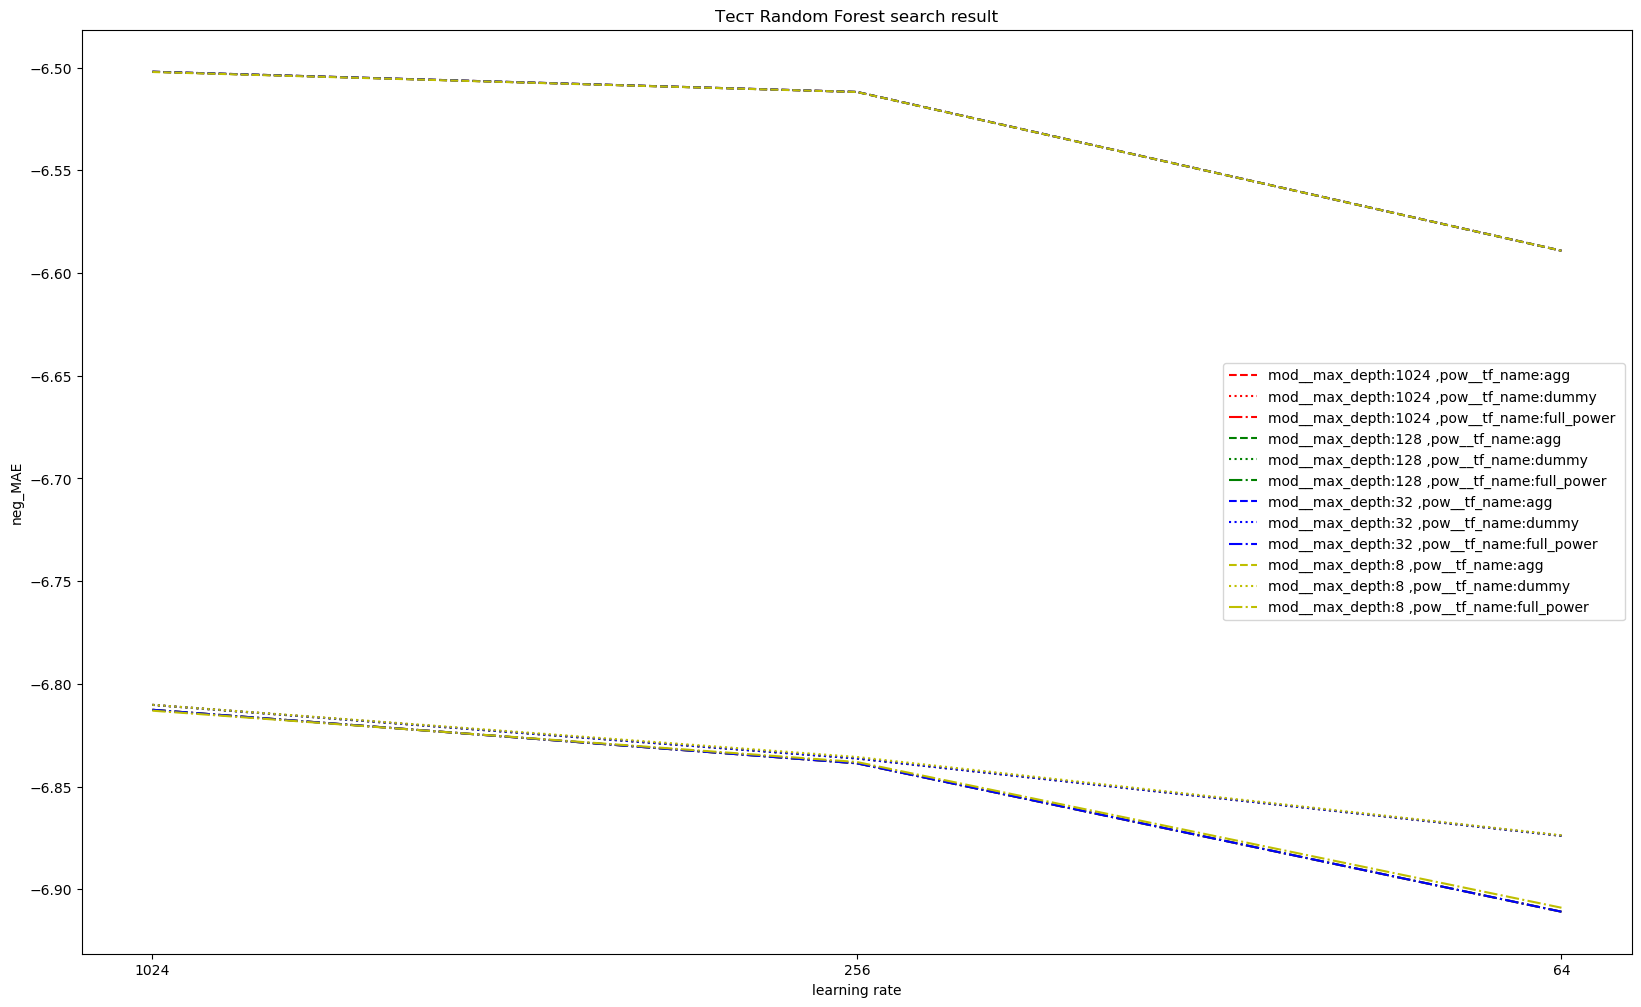

In [57]:
ResultPlotter(rf_sel,{'title':'Random Forest search result','metric':'neg_MAE'}).plot()

Модель RandomForest от LGBM показала заметно худшие результаты , но еще подходящие под условия проекта (MAE 6.5 при требуемых 6.8).   
Результат абслютно не зависит от глубины дерева, но заметно зависит от количества деревьев.
Как и в линейной модели, предварительные трансформеры не сильно влияют на результат, но эффективность обратная - лучше всего показал себя аггрегатор плавок, хуже всего - тривиальный трансформер.  
Предполагаю, что большое число признаков создает проблемы для этой модели

### MLP Regressor

Протестирована простая нейронная сеть , в основном я экспеременитровал со структурой уровней,   
предполагая, что их размеры должны соответствовать числу актальных параметров

In [58]:
%%time
power_tf = PowerTransformer()
scaler = StandardScaler()
model = MLPRegressor( max_iter =16_000,random_state=RANDOM_STATE)
scoring=['neg_mean_absolute_error','r2']
refit = scoring[0]
tier_levels = [len(tier1_cols+tier2_cols+tier3_cols),len(tier1_cols+tier2_cols),len(tier1_cols),len(tier1_cols)//2,8]

params_grid = {
    'mod__hidden_layer_sizes':[ [8] , [128,64,32,16],[128,64,64,32,32,16,16],tier_levels ],
    'mod__learning_rate_init':  [.8,.6,.4,.2,.1,.05],
    'mod__epsilon':[1e-8],#,1e-6,1e-4,1e-2],
    'mod__solver': ['adam']     
}

pipe = Pipeline( [['pow', power_tf],['sca',scaler],['mod',model]])
mlp_gcv = GridSearchCV(pipe,params_grid,cv =4,scoring=scoring,refit=refit)
mlp_gcv.fit(df_tr[X],df_tr[y])
mlp_gcv.best_score_,mlp_gcv.best_params_

CPU times: user 6min 40s, sys: 60 ms, total: 6min 40s
Wall time: 6min 40s


(-7.969312983845782,
 {'mod__epsilon': 1e-08,
  'mod__hidden_layer_sizes': [109, 53, 31, 15, 8],
  'mod__learning_rate_init': 0.4,
  'mod__solver': 'adam'})

In [59]:
mlp_gcv.cv_results_

{'mean_fit_time': array([ 0.11731374,  0.11526078,  0.18021709,  0.17701995,  0.37113428,
         2.63359392,  0.12754667,  3.22254139, 12.35461831, 17.65344214,
         0.85680962,  0.70473051,  0.29344523,  0.15767139,  0.15469897,
        25.36780131, 10.9167459 ,  0.94372666,  0.1481812 ,  5.6336413 ,
        11.45479912,  4.20507824,  0.87334949,  0.56199014]),
 'std_fit_time': array([2.50344764e-02, 2.85003793e-02, 2.73164379e-02, 4.19829712e-02,
        9.62898919e-02, 2.95271971e+00, 1.42467423e-02, 5.37359742e+00,
        3.99212345e-01, 9.43428912e-01, 2.23927982e-01, 1.40782604e-01,
        2.02811490e-01, 7.51329639e-03, 5.59210855e-03, 1.10109248e+00,
        1.76407968e+01, 1.57426557e-01, 8.83720017e-02, 5.36367287e+00,
        7.89235967e-01, 6.05688238e+00, 6.19182202e-01, 6.85492561e-02]),
 'mean_score_time': array([0.00364476, 0.00342184, 0.00323141, 0.0033825 , 0.0032227 ,
        0.00320745, 0.00459677, 0.0035044 , 0.00380725, 0.00429243,
        0.00440937, 0.00

In [60]:
mlp_pars = ParsedResult(mlp_gcv.cv_results_,metric_name='neg_mean_absolute_error')
#idx = pd.IndexSlice
mlp_sel = mlp_pars.select('mod__learning_rate_init')#.loc[:,idx[:,:,'gbdt']] 
mlp_sel

mean_test_neg_mean_absolute_error                    \
mod__hidden_layer_sizes              [109, 53, 31, 15, 8] [128, 64, 32, 16]   
mod__learning_rate_init                                                       
0.05                                           -54.387286        -57.634429   
0.1                                            -19.792520        -56.879808   
0.2                                            -54.858608         -7.971693   
0.4                                             -7.969313         -7.971188   
0.6                                           -404.909698      -1198.462290   
0.8                                          -1303.794416      -1596.858402   

                                                                  
mod__hidden_layer_sizes [128, 64, 64, 32, 32, 16, 16]        [8]  
mod__learning_rate_init                                           
0.05                                       -74.709905 -33.624033  
0.1                                       -430.677614 -41.314535  
0.2                                         -7.969882 -47.313360  
0.4                                      -1595.138343 -47.555209  
0.6                                      -1596.076491 -48.023090  
0.8                                      -1199.753883 -51.280894

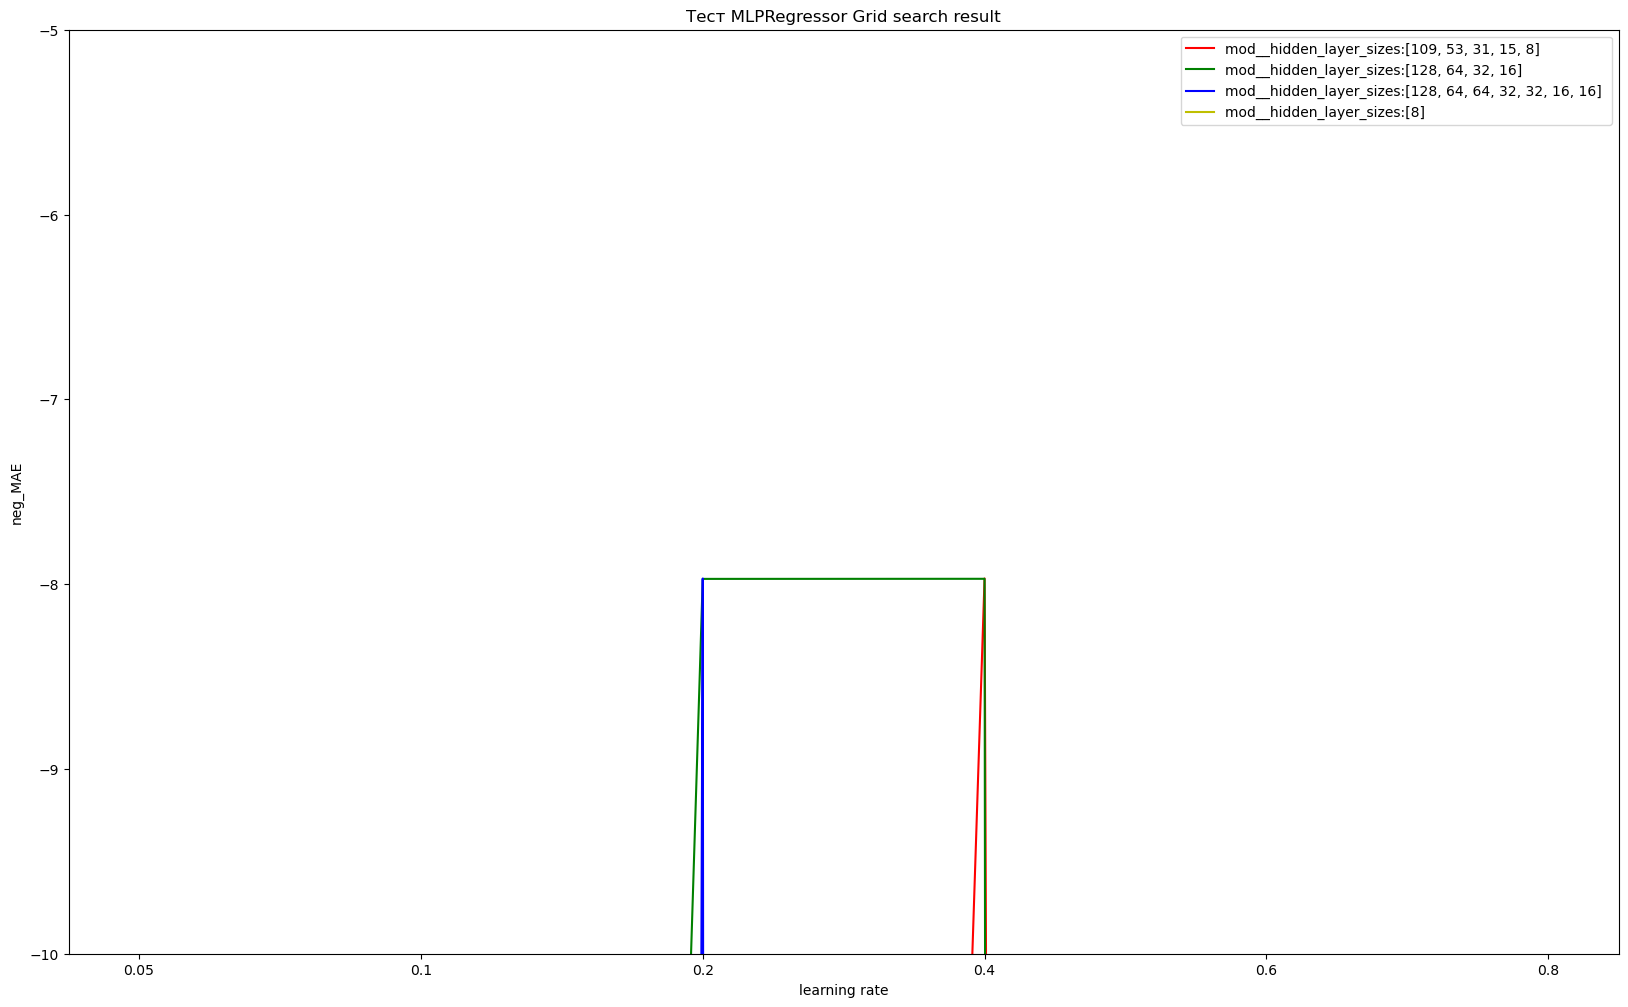

In [61]:
ResultPlotter(mlp_sel,{'title':'MLPRegressor Grid search result','metric':'neg_MAE'}).plot()
plt.ylim(-10,-5);
plt.show()

С нейронной сетью не удалось достигнуть требуемого результата, лучшая метрика MAE = 7.97   
Анализ параметров не имеет особого смысла, в большинстве случаев обучение срывалось.     
Можно тольок констатировать для большинства стратегий максимум метрики при скоростях обучения 0.2-0.4

<font color=darkred size=3><b> Disclaimer!</b></font>  
Перед отправкой работы я понял, что видимо допустил логическую ошибку.  
Стремясь сохранить все данные, я развертывал плавки по колонкам, но мы заранее не знаем, сколько будет этих плавок.  
Поэтому, если их стабильно будет больше 15 , модель будет давать неверные результаты для таких долгих процессов.
Так что правильние видимо проводить трансформацию в средние значения, тем более, что метрика получается только на 0.2 хуже,  а у некоторых моделей даже лучше.  
И рассчитывать средние в этом случае надо конечно в загрузочном запросе.   
С другой стороны, если количество добавок будет больше 15, модель тоже придется переобучать.
Так что надо видимо обсудить с технологами, какие возможны изменения, и что именно можно упрощать в расчетах  

Так как сам я не могу уверенно принять решение, я сдаю проект в том виде, в каком он есть

## Выводы
* Моделирование позволяет предсказывать температуру с метрикой <b>MAE=5.6</b>
* Рекомендуется модель с низкими параметрами eta0 ~ 0.001
* Рекомендуется выгружать  в данных не время , полные моменты событий с датой
* ДЛя моделирования важны регулярные измерения температуры, поэтому надо выяснить причины несовпадения серий измерений с производственными операциями